In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from learning_lidar.utils import global_settings as gs


In [8]:
# set visualization
import seaborn as sns
from learning_lidar.utils import vis_utils
from matplotlib import font_manager
vis_utils.set_visualization_settings()
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.ticker.ScalarFormatter(useMathText = True)

from learning_lidar.learning_phase.learn_utils.nn_analysis_utils import plot_pivot_table,generate_results_table


sns.set_theme()
sns.set_style("whitegrid" ) #{"grid.color": ".6", "grid.linestyle": "--"}
sns.set_palette(sns.color_palette(sns.color_palette("husl", 4)))
sns.color_palette("husl", 5)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522)]

In [9]:
load_preloaded_results = True
overlap = False
results_folder = os.path.join(gs.PKG_ROOT_DIR, 'results')
save_fig = True
figures_folder = os.path.join(os.path.abspath(os.curdir),'figures')


# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [10]:
if not load_preloaded_results:
    total_results = generate_results_table(results_folder=results_folder,experiments_table_fname='runs_board.xlsx')
else:
    current_res_fname = os.path.join(results_folder,'remote_total_results.csv')
    total_results = pd.read_csv(current_res_fname)


In [11]:
use_bg = []
wavelengths = []
for idx, row in total_results.iterrows():
        flag_bg = row.use_bg

        if type(flag_bg) == str:
            if flag_bg == 'False' or flag_bg == 'True':
                use_bg.append(eval(flag_bg))
            else:
                use_bg.append(flag_bg)
        else:
            use_bg.append(flag_bg)
        wavelengths.append(int(row.wavelength) if not(row.wavelength=='all') else row.wavelength)
total_results['use_bg'] = use_bg
total_results['wavelength'] = wavelengths

In [12]:
analyse_results = total_results[total_results.training_iteration>=1].copy()
analyse_results = analyse_results[analyse_results.overlap==overlap]
analyse_results = analyse_results[analyse_results.u_hsize]
time_str = r'$\rm Time [sec]$'
mareloss_str = r'$\rm MARELoss\,[\%]$'
analyse_results.rename(columns = {'time_total_s':time_str,'MARELoss':mareloss_str},inplace=True)
analyse_results[mareloss_str]*=100
lidar_res = analyse_results[analyse_results.source=='lidar'].copy()
#idar_res = lidar_res[lidar_res.use_bg==False]
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res['use_power']!='False' )].copy()
all_wav = analyse_results #[analyse_results.wavelength=='all']
all_wavs_configABCD = all_wav[all_wav.config!='Other'].copy()


# common settings for plottins

fig_format = 'svg'
figsize = (5,4)

## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar

C:\Users\addalin\AppData\Local\Temp\ipykernel_30516\3843925429.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = comon_pow[comon_pow['db']=='initial'][comon_pow['wavelength']!='all']


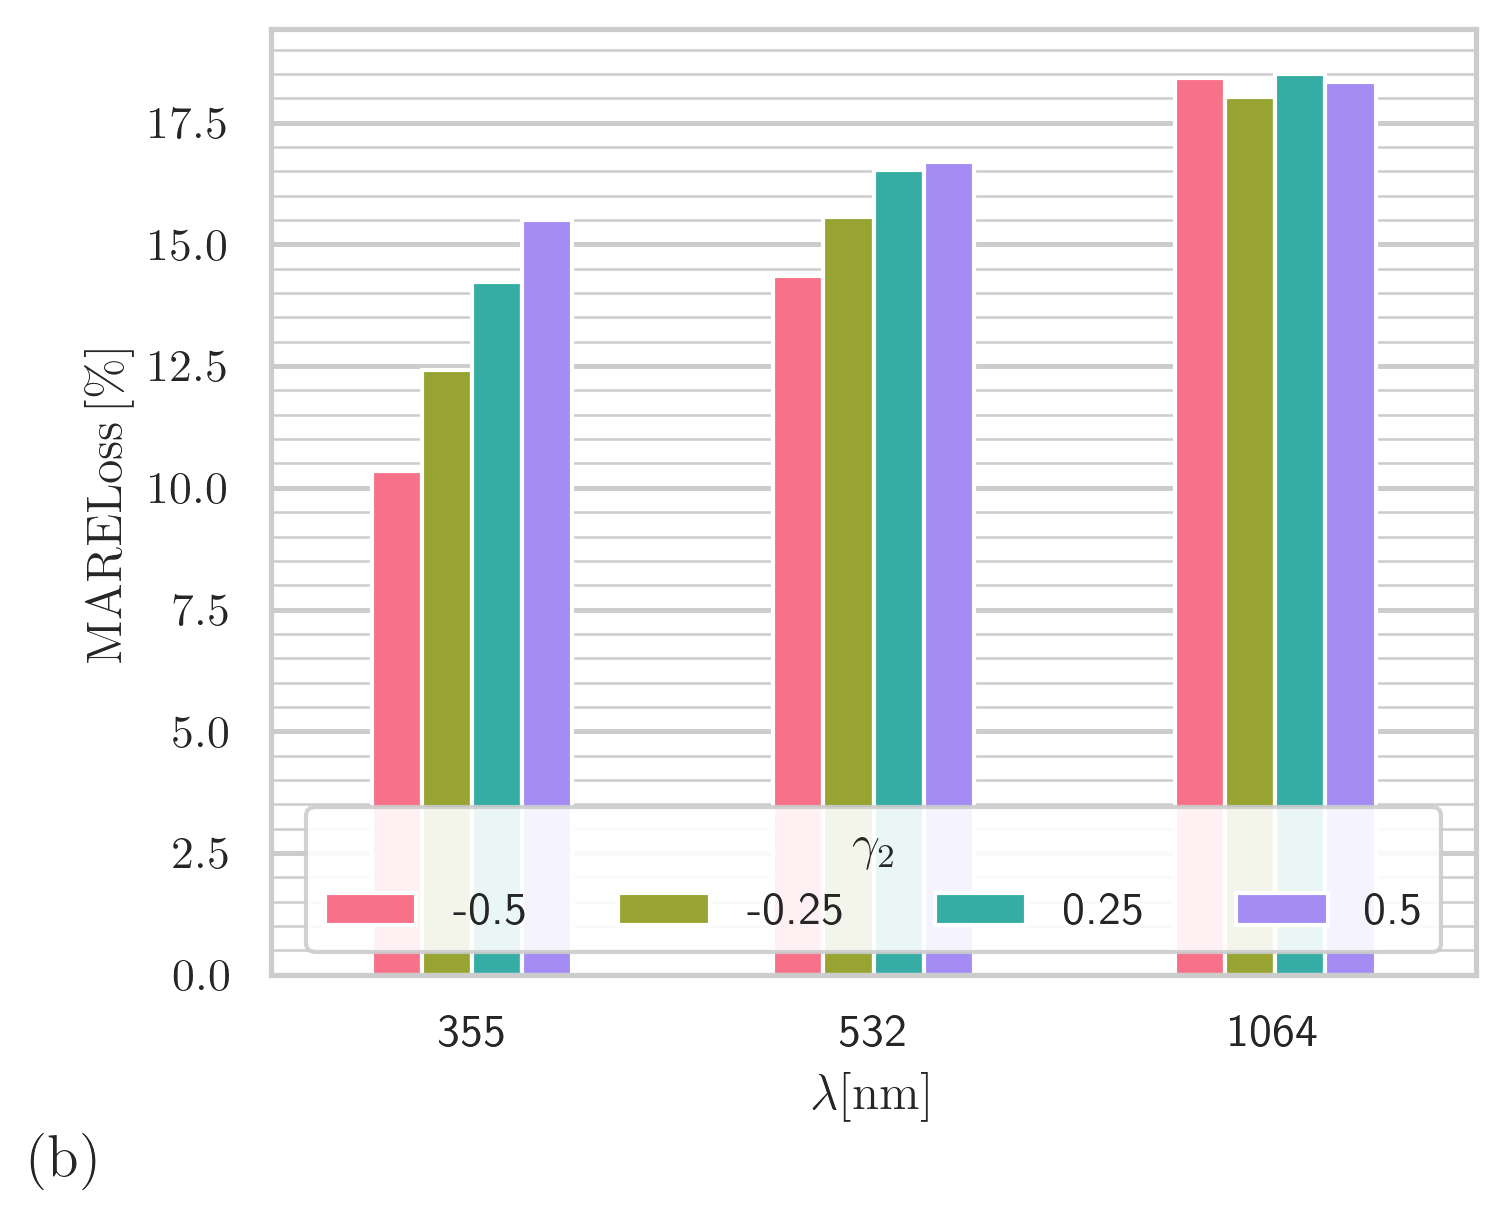

NameError: name 'vis_utils' is not defined

<Figure size 1800x1200 with 0 Axes>

In [13]:
#plt.style.use('seaborn-whitegrid')
#plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
powers_list = [0.5,0.25,-0.25,-0.5]
comon_pow = pow_lidar[[px2 in powers_list for px2 in pow_lidar['pow_x2']]] #,-0.1,-0.3,
data = comon_pow[comon_pow['db']=='initial'][comon_pow['wavelength']!='all']
p_table = pd.pivot_table(data, values=[mareloss_str], columns= ['pow_x2'], index=['wavelength'], aggfunc=np.mean)
p_table.columns.rename({'pow_x2':r'$\gamma_2$'}, inplace=True)
p_table.index.name =r'$\lambda[\rm nm]$'
p_table.columns = p_table.columns.droplevel(0)
fig_txt ={'locx':0.0,'locy':0.0, 'str':r'$\rm (b)$'}

fig, ax, fpath= plot_pivot_table(p_table, figsize=figsize, save_fig=save_fig,vis_title=False,
                 legend_col=len(powers_list), legend_loc='lower center', fig_txt=fig_txt,
                 y_label=mareloss_str,fig_path=figures_folder,format_fig=fig_format,
                 title=r'Comparing the average effect of different gamma 2 values on performance')


## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

C:\Users\addalin\AppData\Local\Temp\ipykernel_14860\3426691817.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = all_wavs_configABCD[all_wavs_configABCD.wavelength==wavelength][all_wavs_configABCD.config==config].copy()


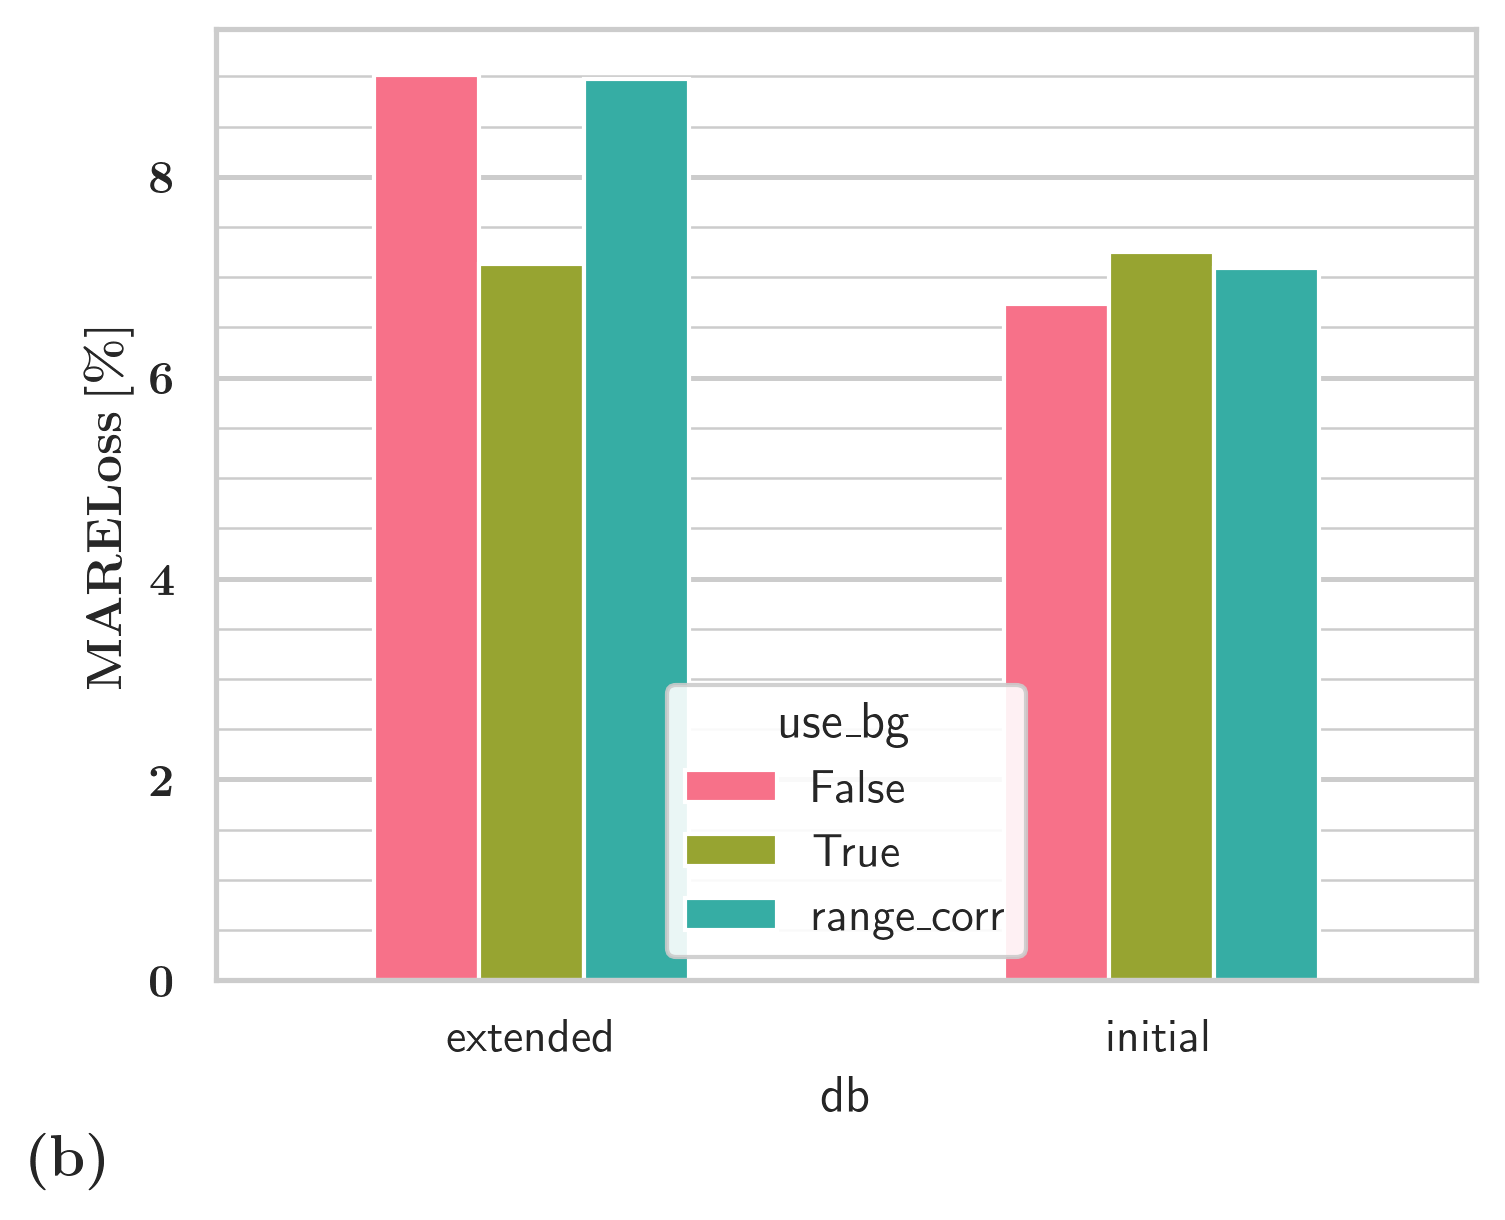

(<Figure size 1500x1200 with 1 Axes>,
 <AxesSubplot:title={'center':'Comparing BG data contribution for DI vs DE at 355 nm'}, xlabel='db', ylabel='$\\rm MARELoss\\,[\\%]$'>,
 'C:\\Users\\addalin\\Dropbox\\Lidar\\lidar_learning\\learning_lidar\\learning_phase\\figures\\Comparing BG data contribution for DI vs DE at 355 nm.svg')

<Figure size 1800x1200 with 0 Axes>

In [44]:
wavelength = 355
config = 'D'
compare_values = [mareloss_str]
data = all_wavs_configABCD[all_wavs_configABCD.wavelength==wavelength][all_wavs_configABCD.config==config].copy()

p_table = pd.pivot_table(data,  values=compare_values, columns= ['use_bg'], index=['db'], aggfunc=np.min)
p_table.columns = p_table.columns.droplevel(0)
fig_txt ={'locx':0.0,'locy':0.0, 'str':r'$\rm (b)$'}
plot_pivot_table(p_table, figsize=figsize, save_fig=save_fig,
                 y_label=mareloss_str,fig_txt=fig_txt,vis_title=False,
                 fig_path=figures_folder,format_fig=fig_format,
                 title=f'Comparing BG data contribution for DI vs DE at {wavelength} nm')

C:\Users\addalin\AppData\Local\Temp\ipykernel_14860\2201853063.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.config!='E'][all_wavs_configABCD.config!='F'][all_wavs_configABCD.config!='H'][all_wavs_configABCD.wavelength=='all'].copy()


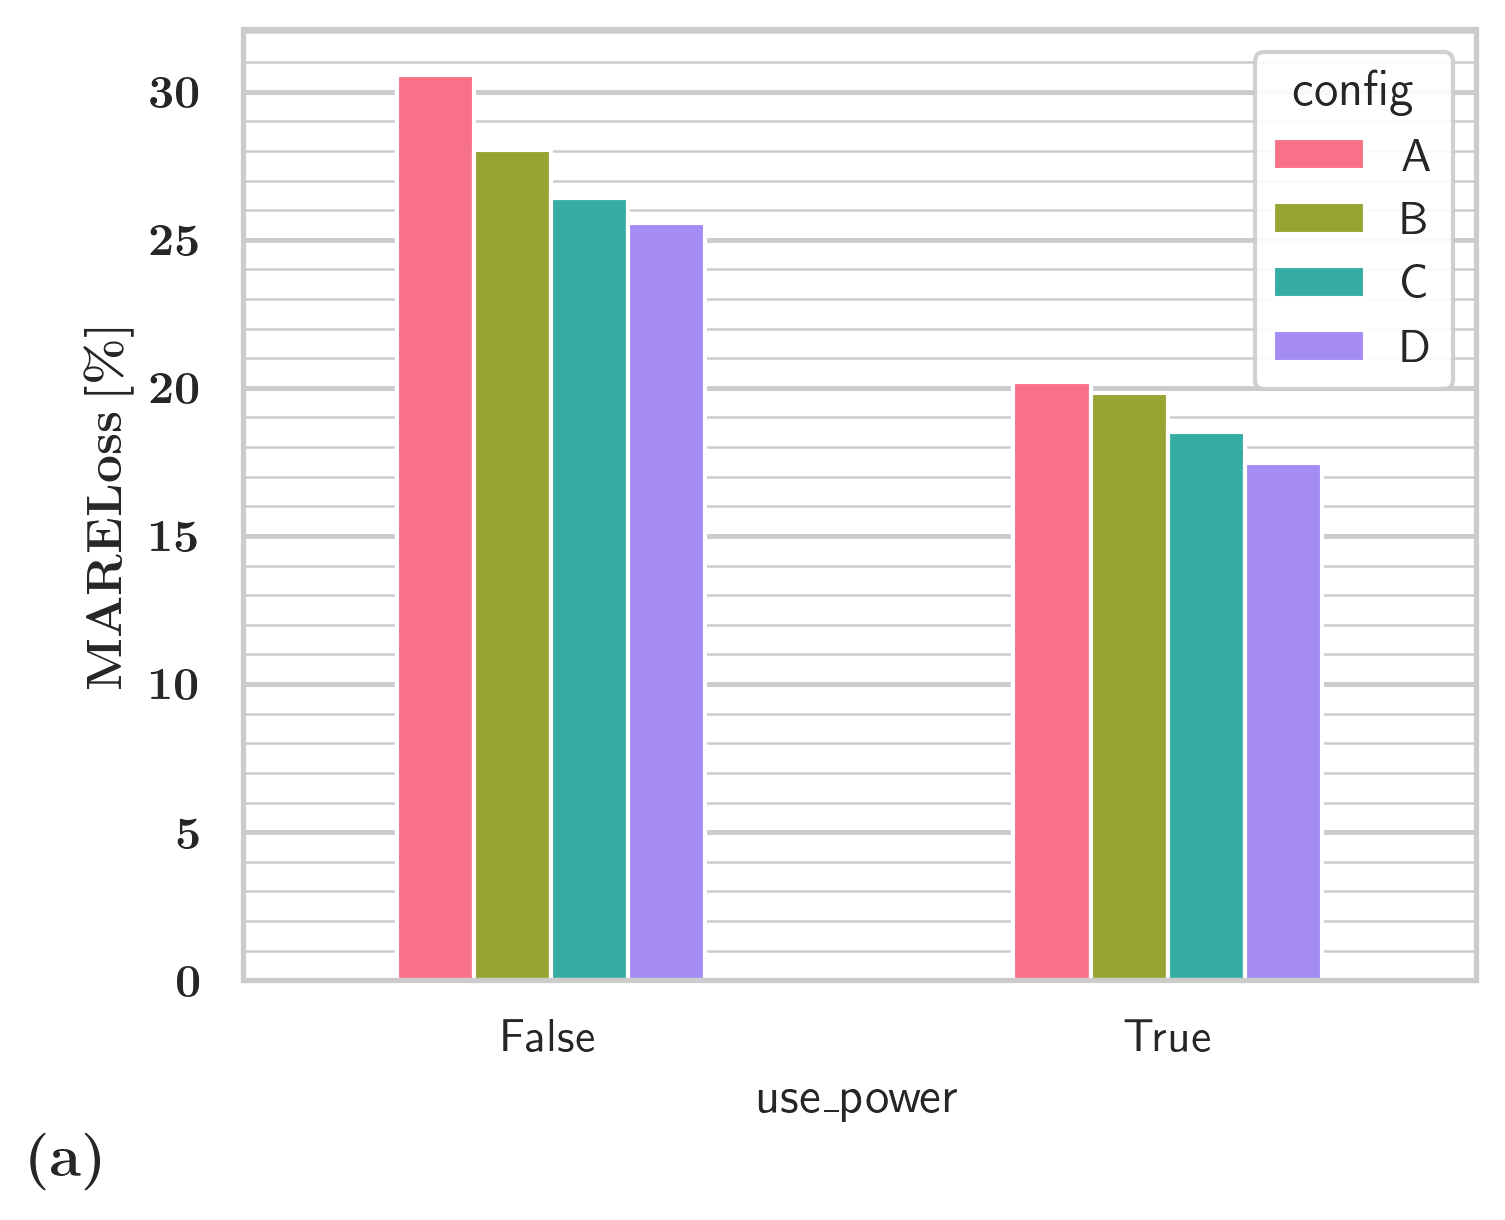

(<Figure size 1500x1200 with 1 Axes>,
 <AxesSubplot:title={'center':'Average loss on initial database - testing config on all wavelengths'}, xlabel='use_power', ylabel='$\\rm MARELoss\\,[\\%]$'>,
 'C:\\Users\\addalin\\Dropbox\\Lidar\\lidar_learning\\learning_lidar\\learning_phase\\figures\\Average loss on initial database - testing config on all wavelengths.svg')

<Figure size 1800x1200 with 0 Axes>

In [16]:
data = all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.config!='E'][all_wavs_configABCD.config!='F'][all_wavs_configABCD.config!='H'][all_wavs_configABCD.wavelength=='all'].copy()
p_table = pd.pivot_table(data,
               values=[mareloss_str],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.mean)
p_table.columns = p_table.columns.droplevel(0)
fig_txt ={'locx':0.0,'locy':0.0, 'str':r'$\rm (a)$'}
plot_pivot_table(p_table, figsize=figsize, save_fig=save_fig,y_label=mareloss_str,
                 fig_path=figures_folder,format_fig=fig_format,fig_txt=fig_txt,vis_title=False,
                 title='Average loss on initial database - testing config on all wavelengths')

C:\Users\addalin\AppData\Local\Temp\ipykernel_14860\693834119.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==True][all_wavs_configABCD.db=='initial'],


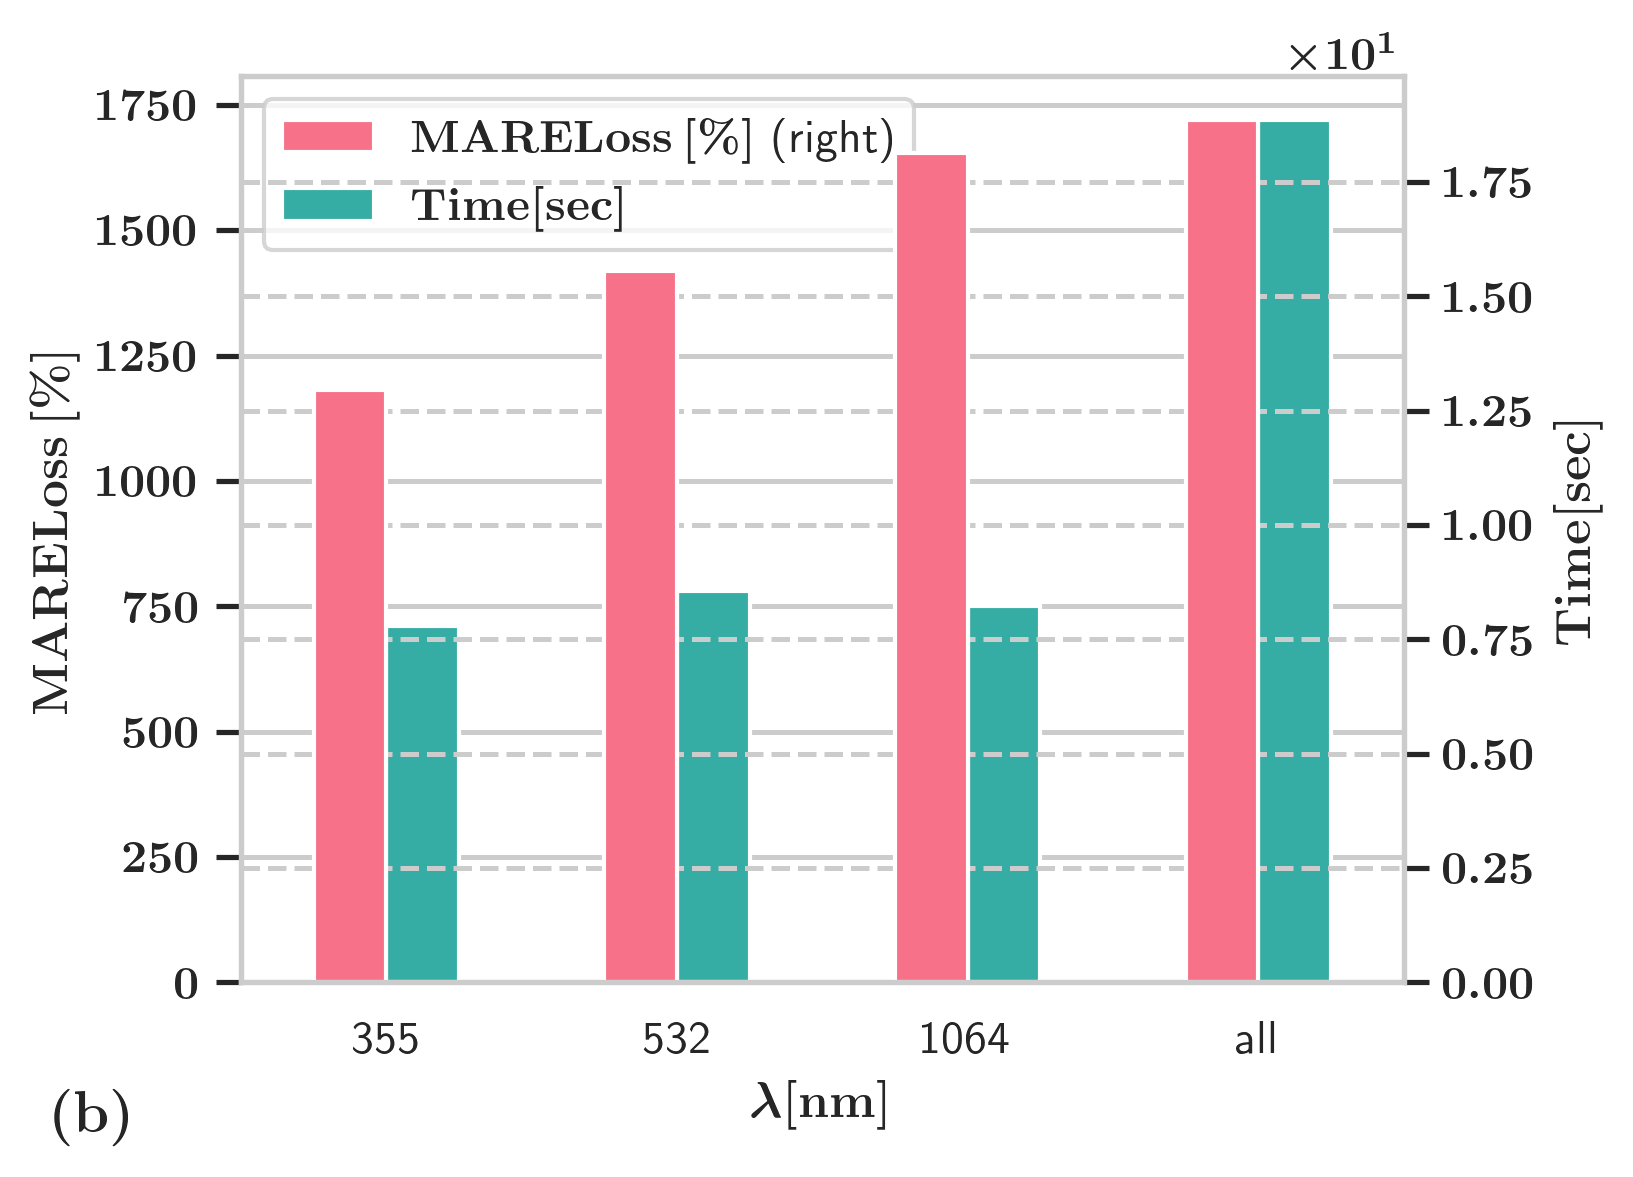

In [60]:
colors = sns.color_palette("husl", 4)
colors = colors[0::2]
sns.set_palette(sns.color_palette(colors))
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==True][all_wavs_configABCD.db=='initial'],
               values=[time_str,mareloss_str ],
               index=['wavelength'],
               aggfunc=np.mean)
p_table.index.name =r'$\lambda[\rm nm]$'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = p_table.plot(kind='bar',secondary_y=time_str, rot= 0 , ax=ax)
ax.right_ax.set_ylabel(time_str)

ax.set_ylabel(mareloss_str)
ax.right_ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.right_ax.grid(visible=True, which='major',linestyle='--', linewidth=1.2, zorder=1)
ax.right_ax.xaxis.grid(False)
ax.grid(visible=True, which='major', linewidth=1.2, zorder=0)
ax.xaxis.grid(False)

fig.text(fig_txt['locx'], fig_txt['locy'], r'$\rm (b)$', fontsize=14)
stitle ='Wavelength separation effect w powers both databases'
ax.set_title(stitle)
ax.title.set_visible(False)
plt.show()
if save_fig:
    fpath = vis_utils.save_fig(fig, stitle=stitle, dst_folder=figures_folder, format_fig=fig_format)
else:
    fpath = ''

In [59]:
p_table.columns
p_table.index

Index([355, 532, 1064, 'all'], dtype='object', name='$\lambda[\rm nm]$')

C:\Users\addalin\AppData\Local\Temp\ipykernel_16908\3949952617.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.wavelength==355][all_wavs_configABCD.use_power==True],


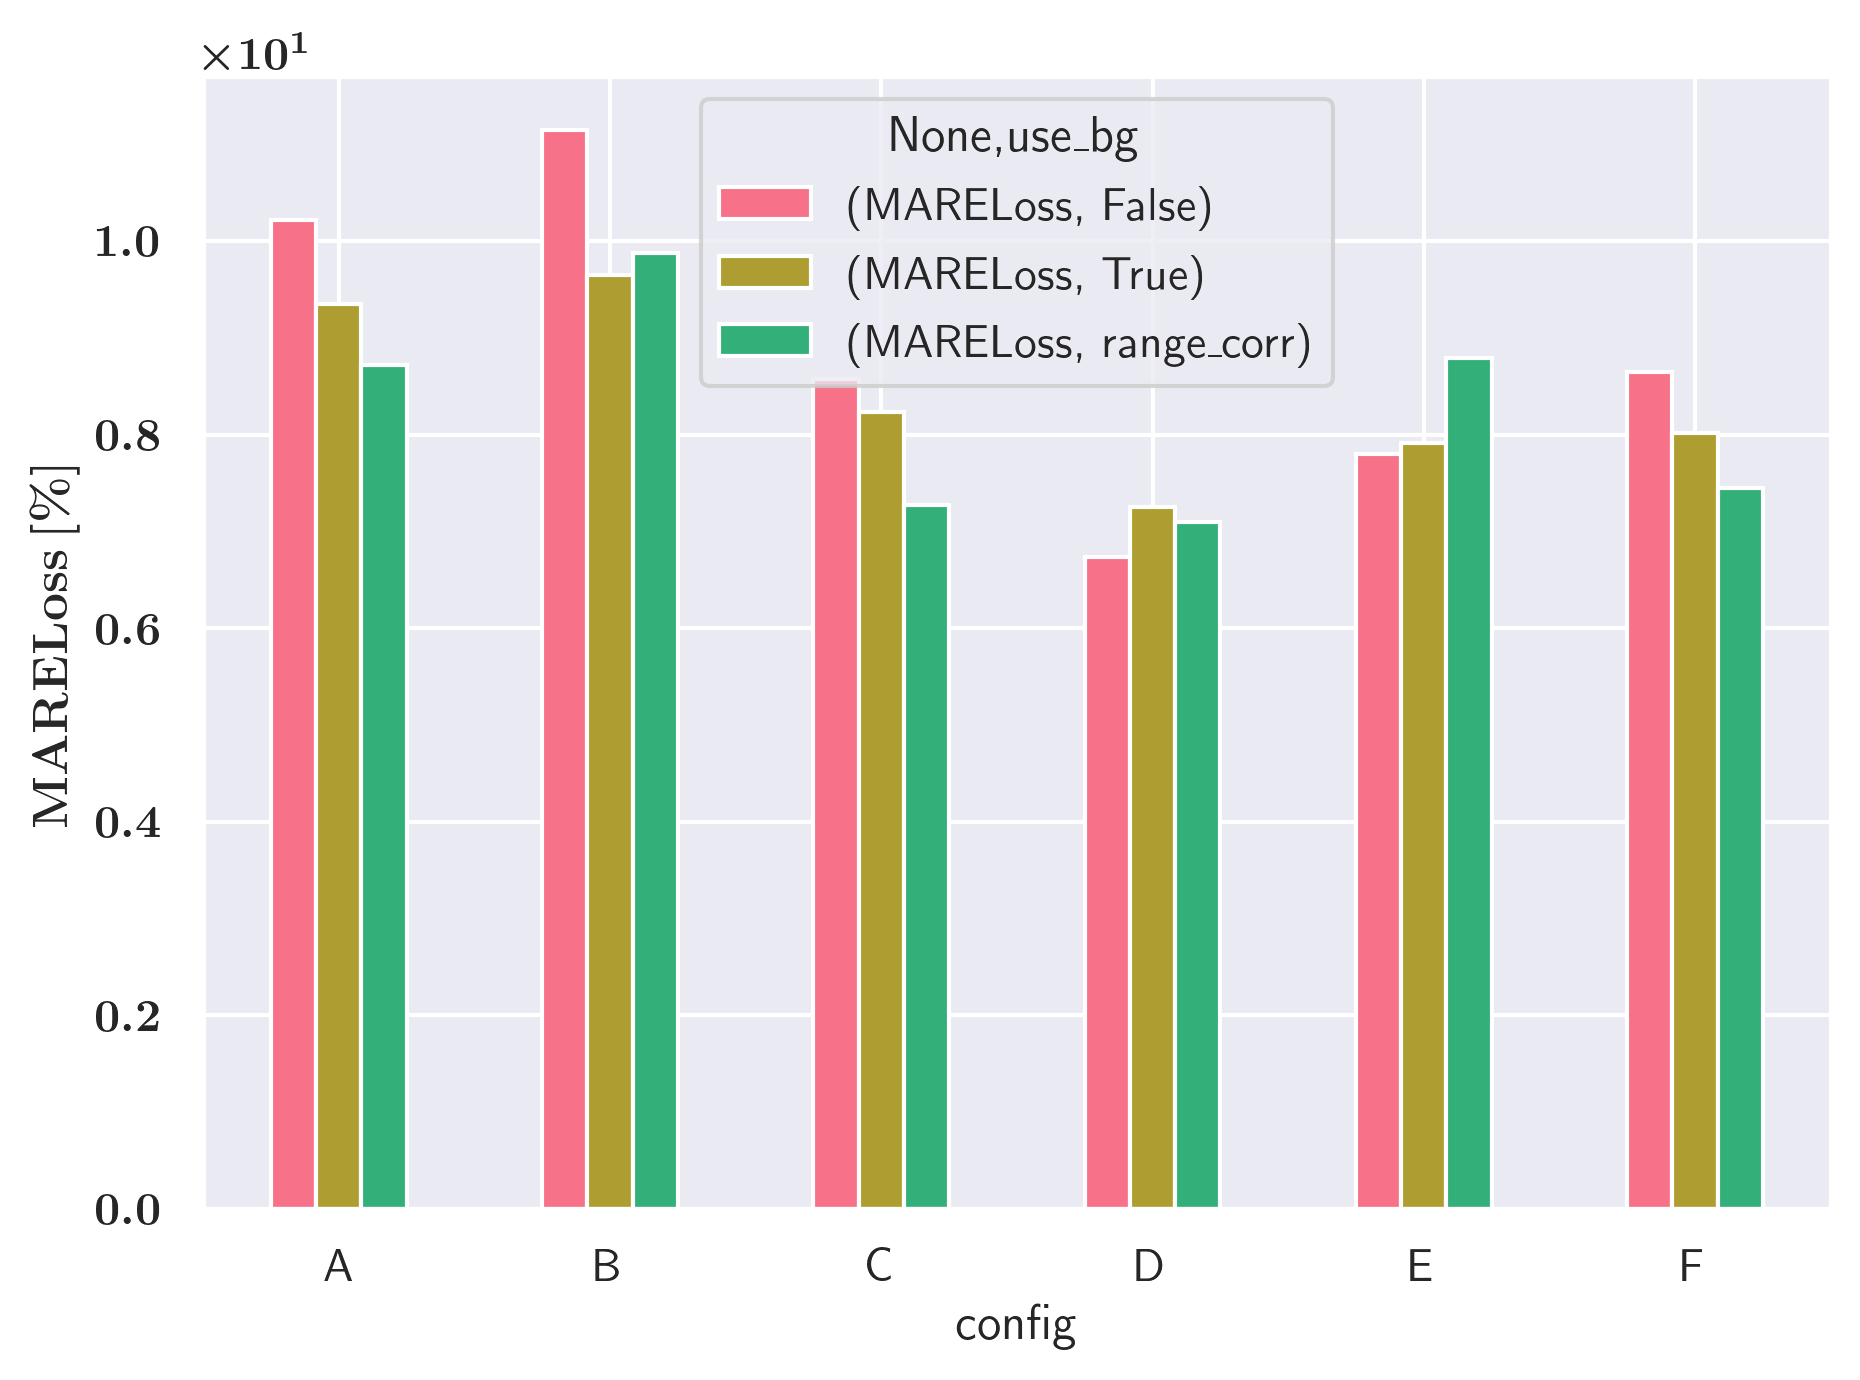

In [70]:
sns.set_palette(sns.color_palette(sns.color_palette("husl", 5)))
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.wavelength==355][all_wavs_configABCD.use_power==True],
               values=['MARELoss'],#, 'Time [sec]'],
               columns= ['use_bg'],
               index=['config'],
               aggfunc=np.min)
ax = p_table.plot(kind='bar', rot= 0 , figsize=(7,5)) #secondary_y= 'Time [sec]' ,
ax.set_ylabel(y_label)
#ax.right_ax.set_ylabel(r'Time [sec]')
#ax.right_ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax.right_ax.grid(True)
#ax.right_ax.set_axisbelow(True)
ax.grid(True)
ax.set_axisbelow(True)
plt.show()

C:\Users\addalin\AppData\Local\Temp\ipykernel_4188\4291974759.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.wavelength==355][all_wavs_configABCD.use_power==True][all_wavs_configABCD.config=='F'],


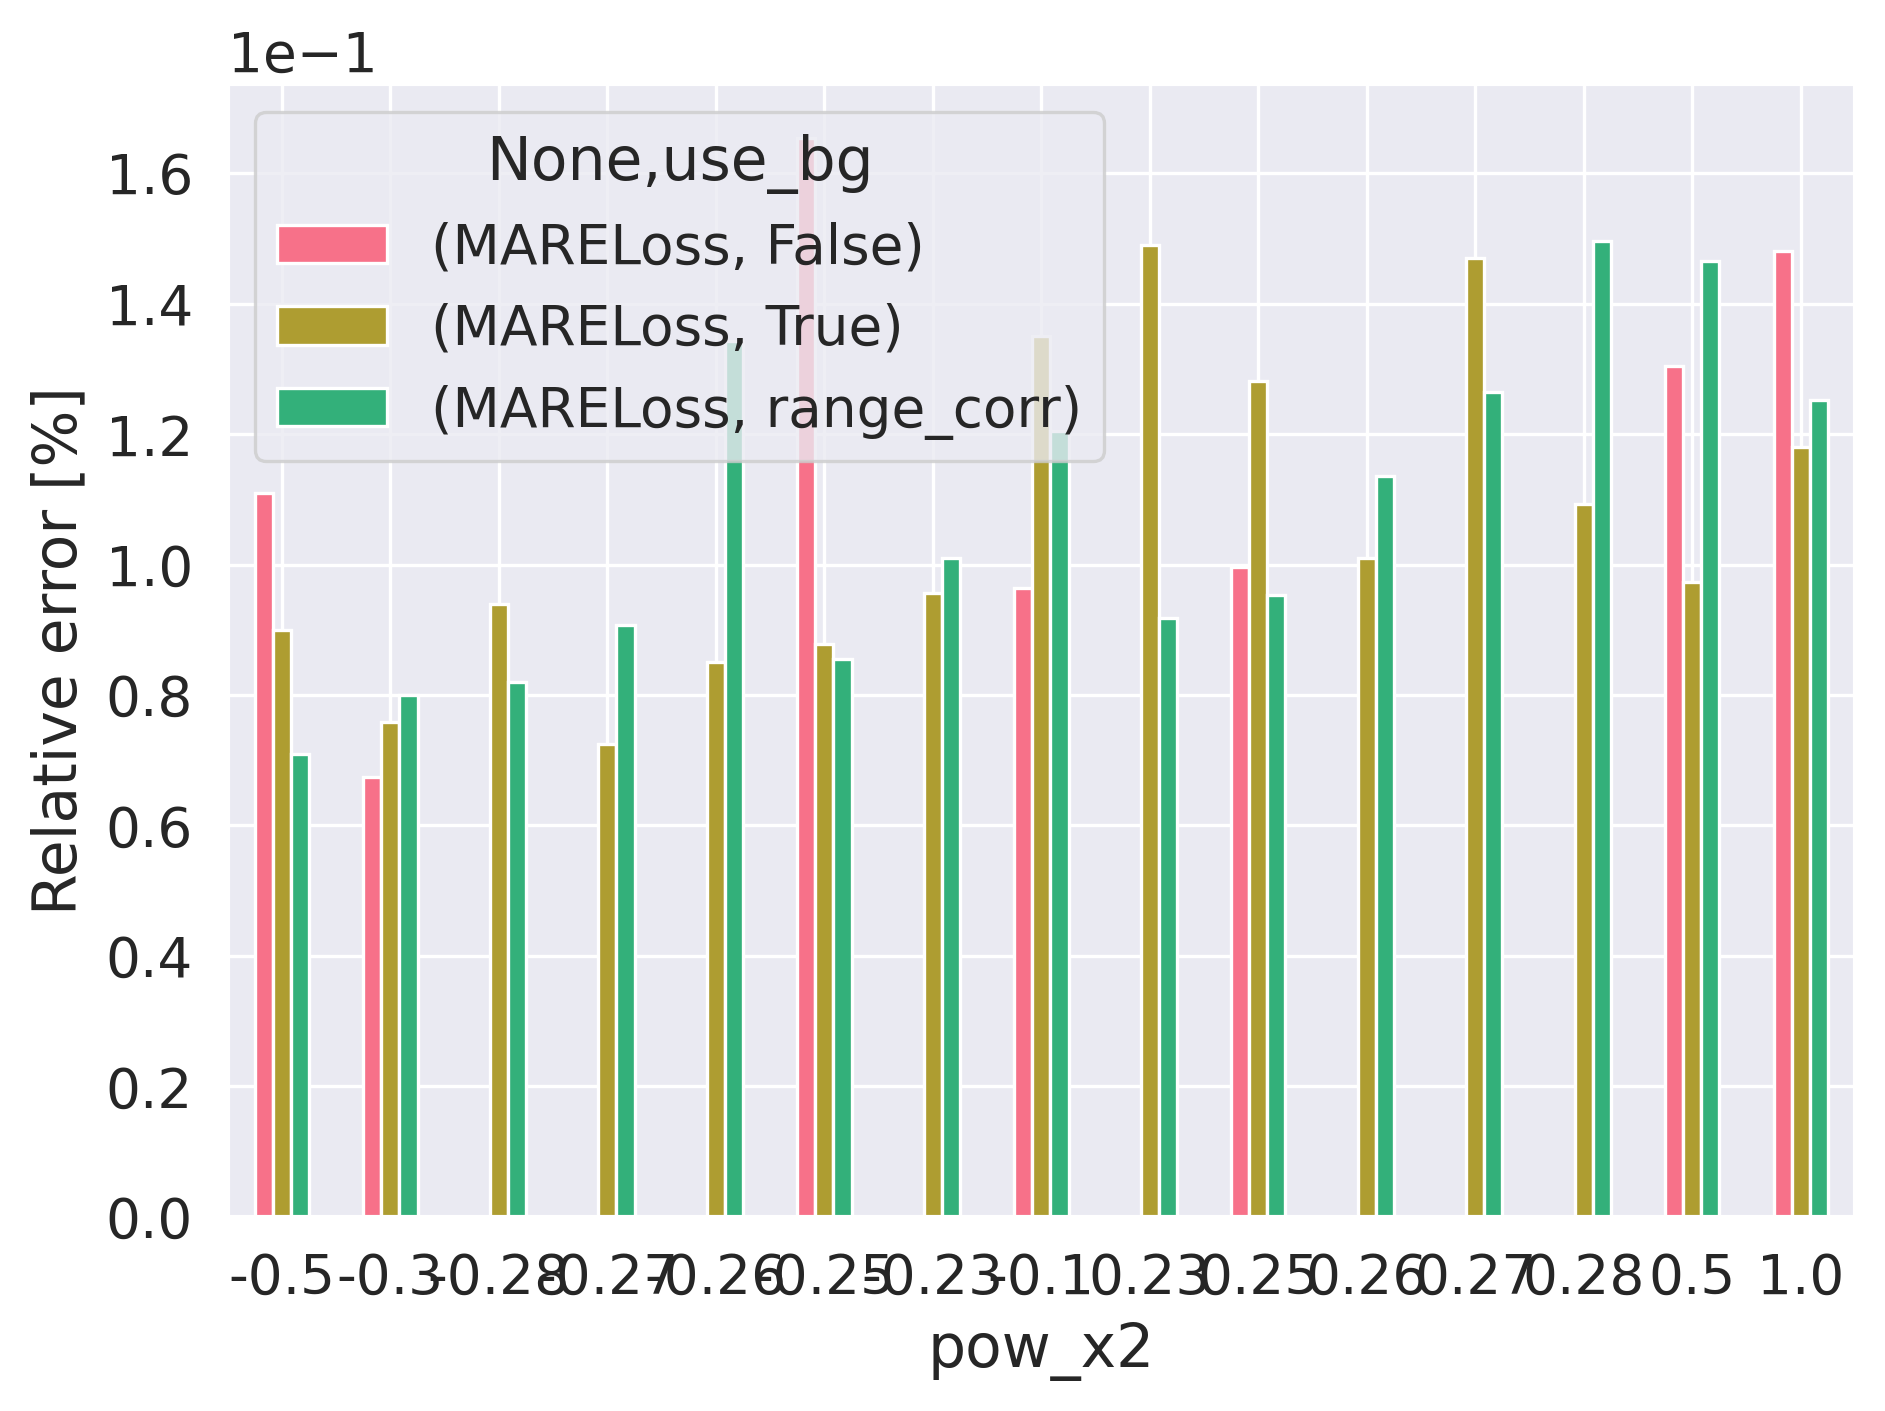

In [174]:
sns.set_palette(sns.color_palette(sns.color_palette("husl", 5)))
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.wavelength==355][all_wavs_configABCD.use_power==True][all_wavs_configABCD.config=='F'],
               values=['MARELoss'],#, 'Time [sec]'],
               columns= ['use_bg'],
               index=['pow_x2'],
               aggfunc=np.min)
ax = p_table.plot(kind='bar', rot= 0 , figsize=(7,5)) #secondary_y= 'Time [sec]' ,
ax.set_ylabel(r'Relative error [%]')
#ax.right_ax.set_ylabel(r'Time [sec]')
#ax.right_ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax.right_ax.grid(True)
#ax.right_ax.set_axisbelow(True)
ax.grid(True)
ax.set_axisbelow(True)
plt.show()

C:\Users\addalin\AppData\Local\Temp\ipykernel_4188\1423422856.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.wavelength==1064][all_wavs_configABCD.use_power==True],


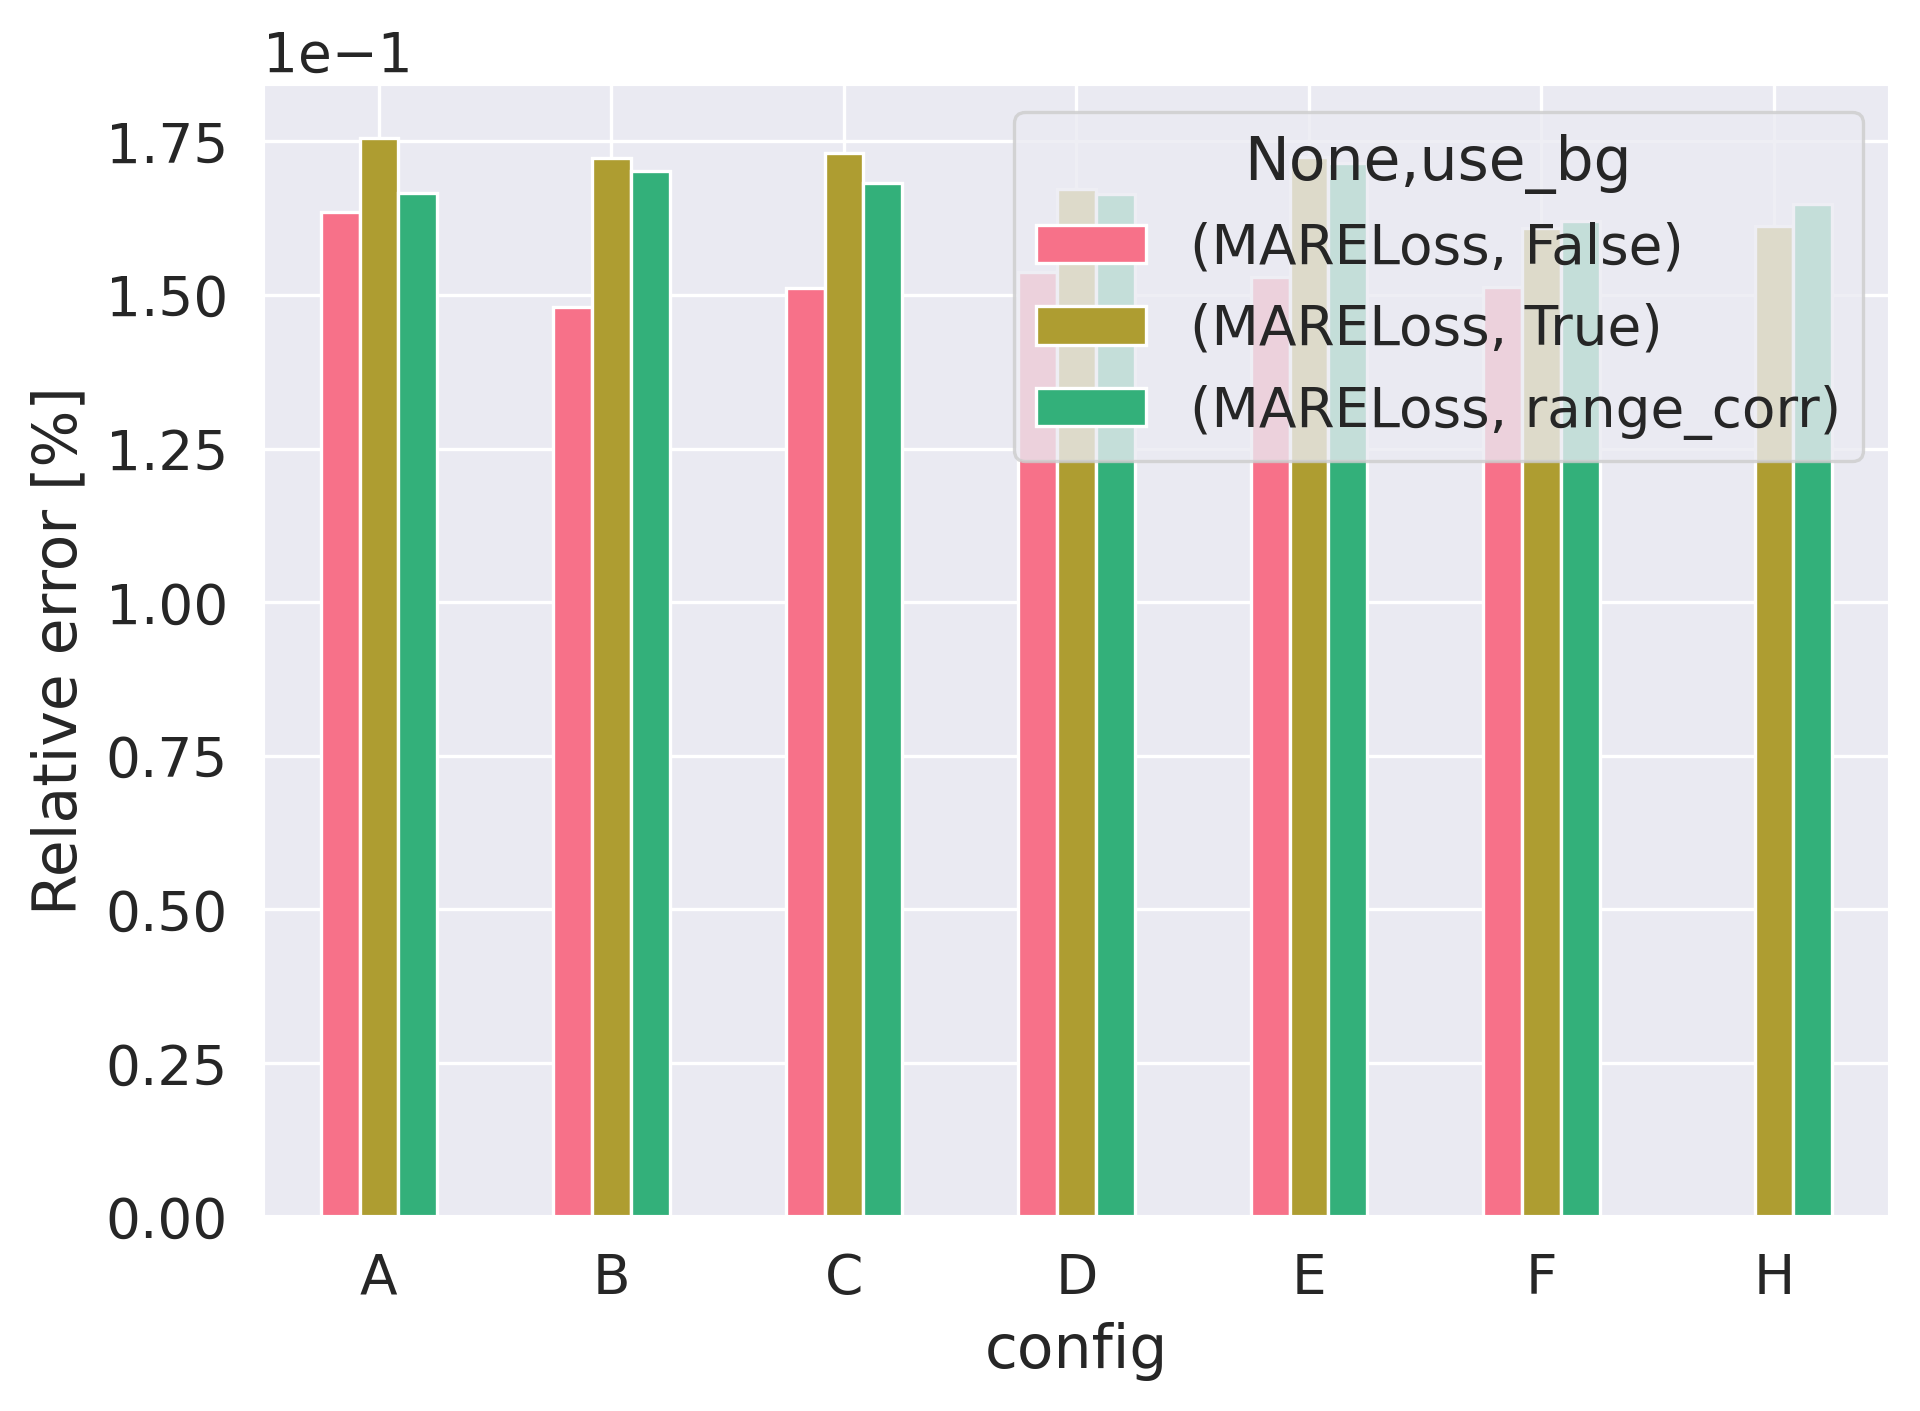

In [129]:
sns.set_palette(sns.color_palette(sns.color_palette("husl", 5)))
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial'][all_wavs_configABCD.wavelength==1064][all_wavs_configABCD.use_power==True][all_wavs_configABCD.use_power==True],
               values=['MARELoss'],#, 'Time [sec]'],
               columns= ['use_bg'],
               index=['config'],
               aggfunc=np.min)
ax = p_table.plot(kind='bar', rot= 0 , figsize=(7,5)) #secondary_y= 'Time [sec]' ,
ax.set_ylabel(r'Relative error [%]')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.grid(True)
ax.set_axisbelow(True)
plt.show()

C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\1615952314.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


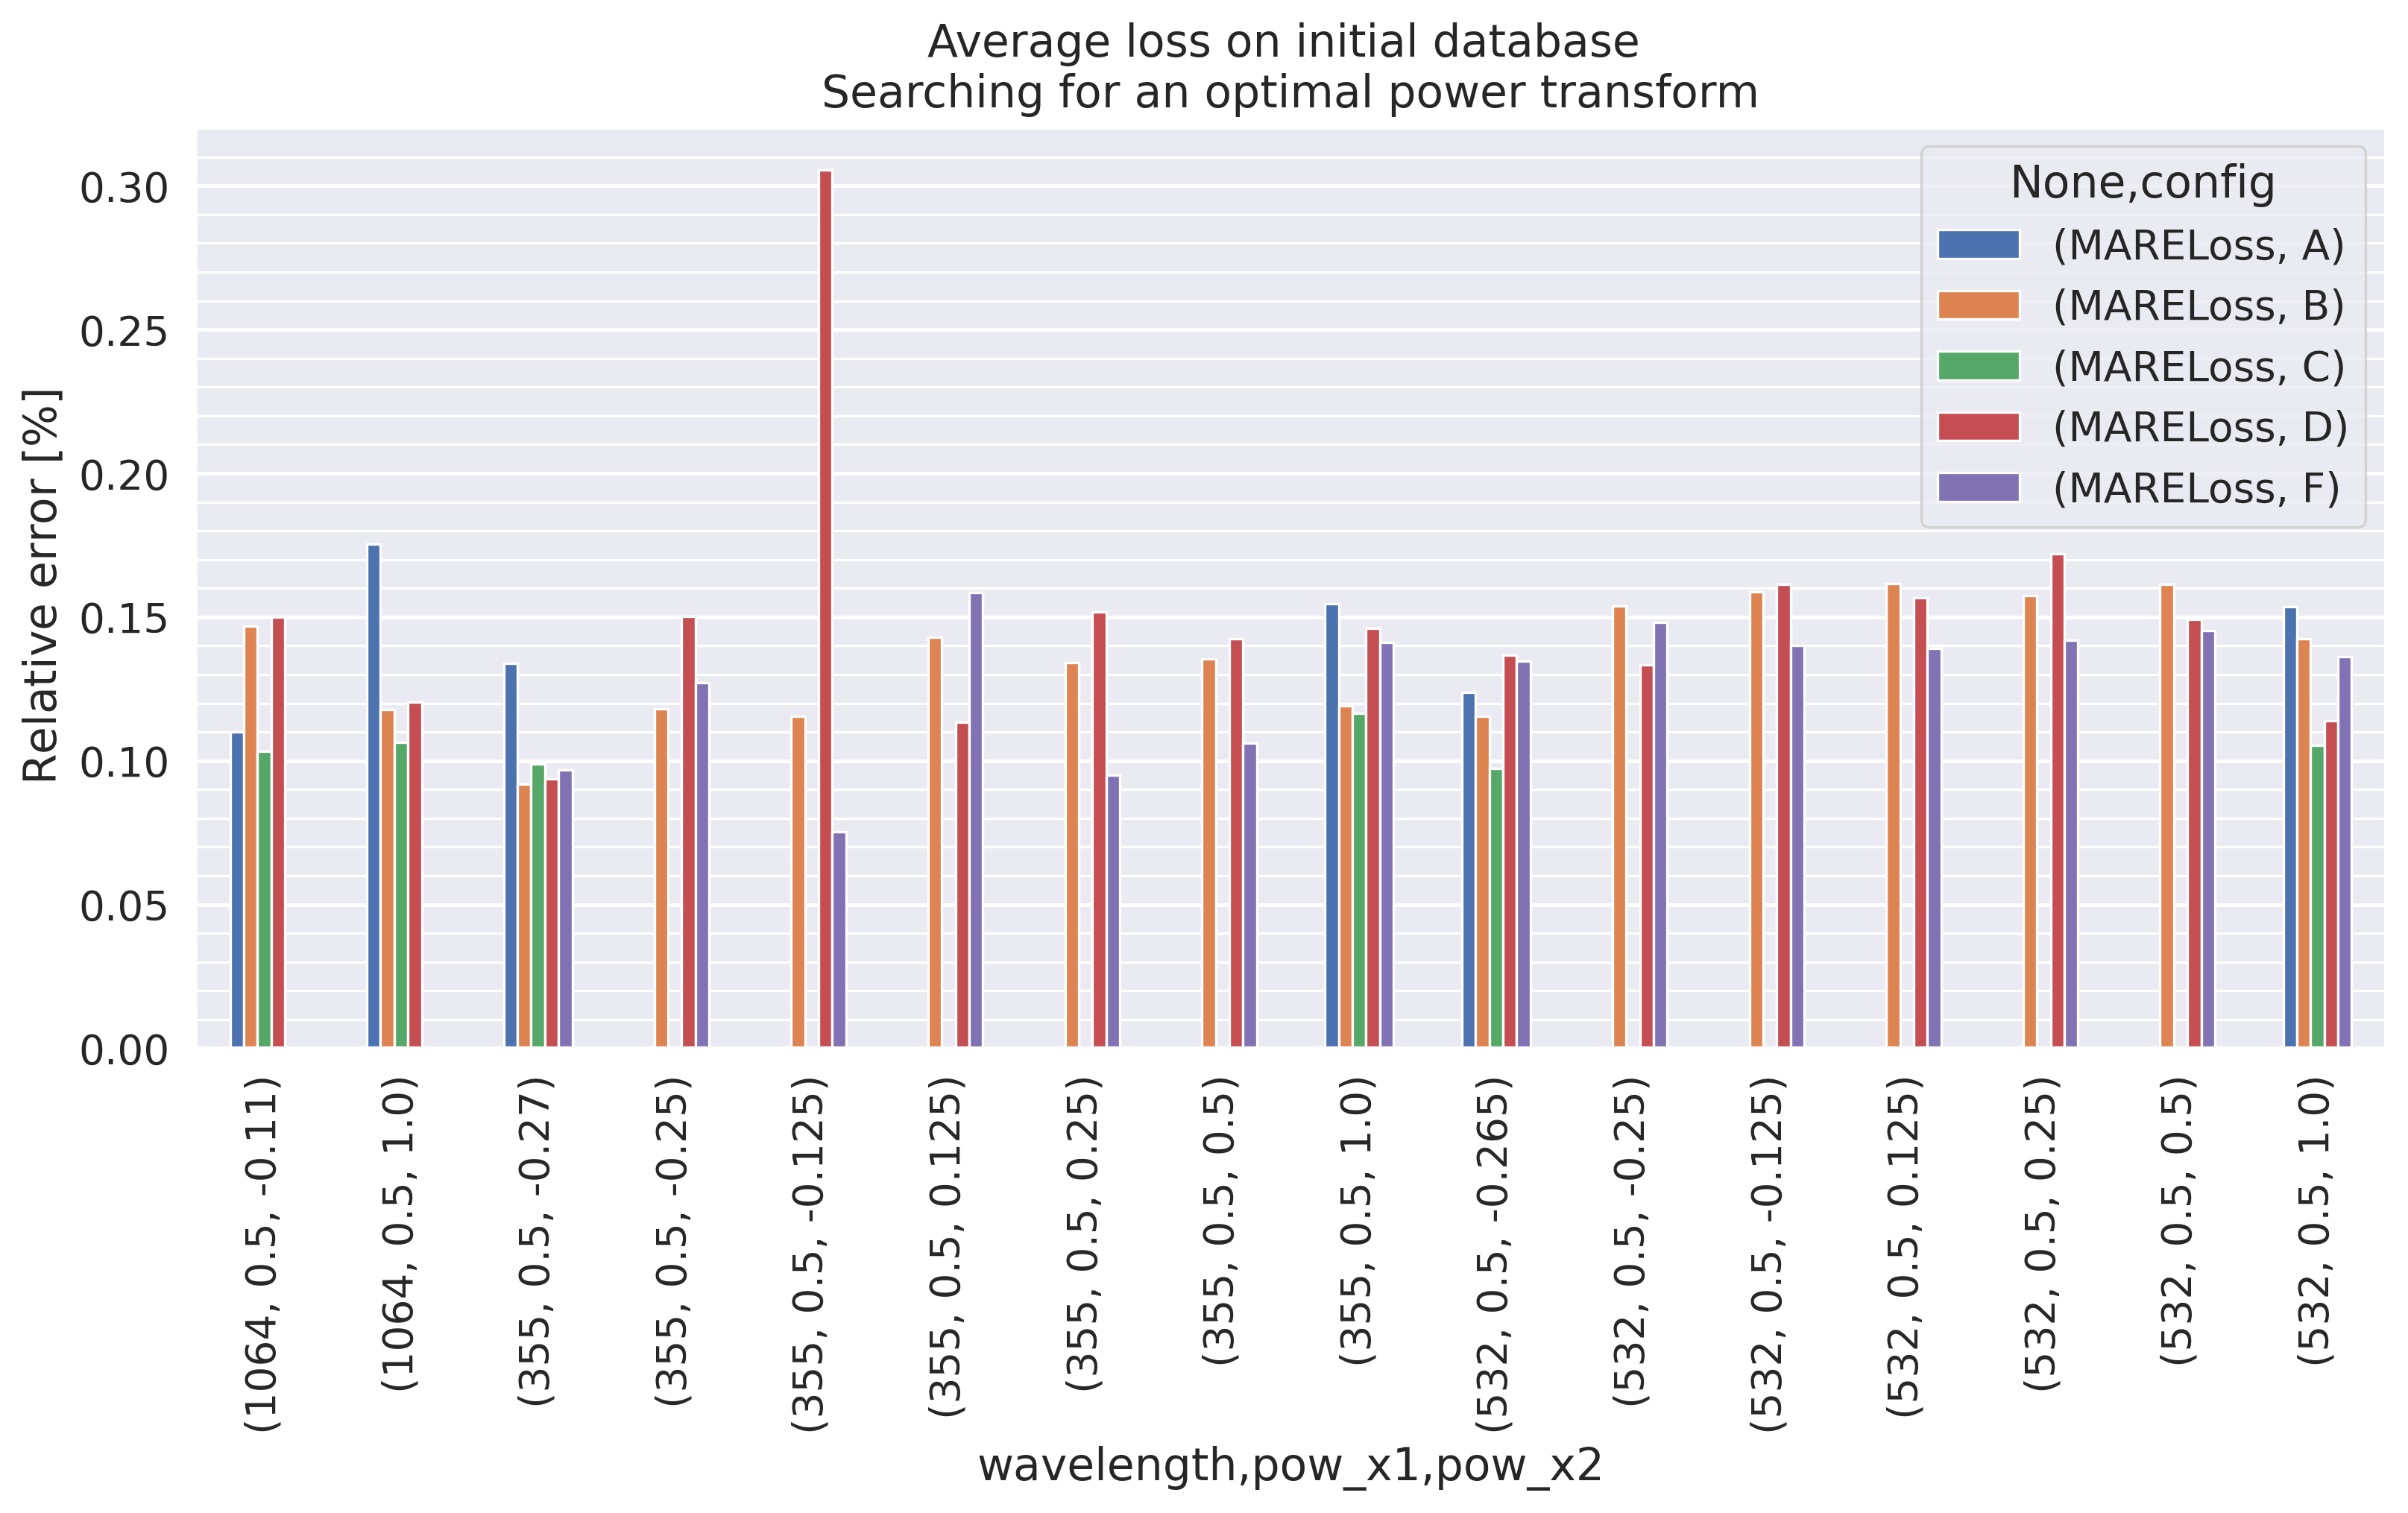

In [29]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.db=='initial'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7),
                 title='Average loss on initial database \n Searching for an optimal power transform ')

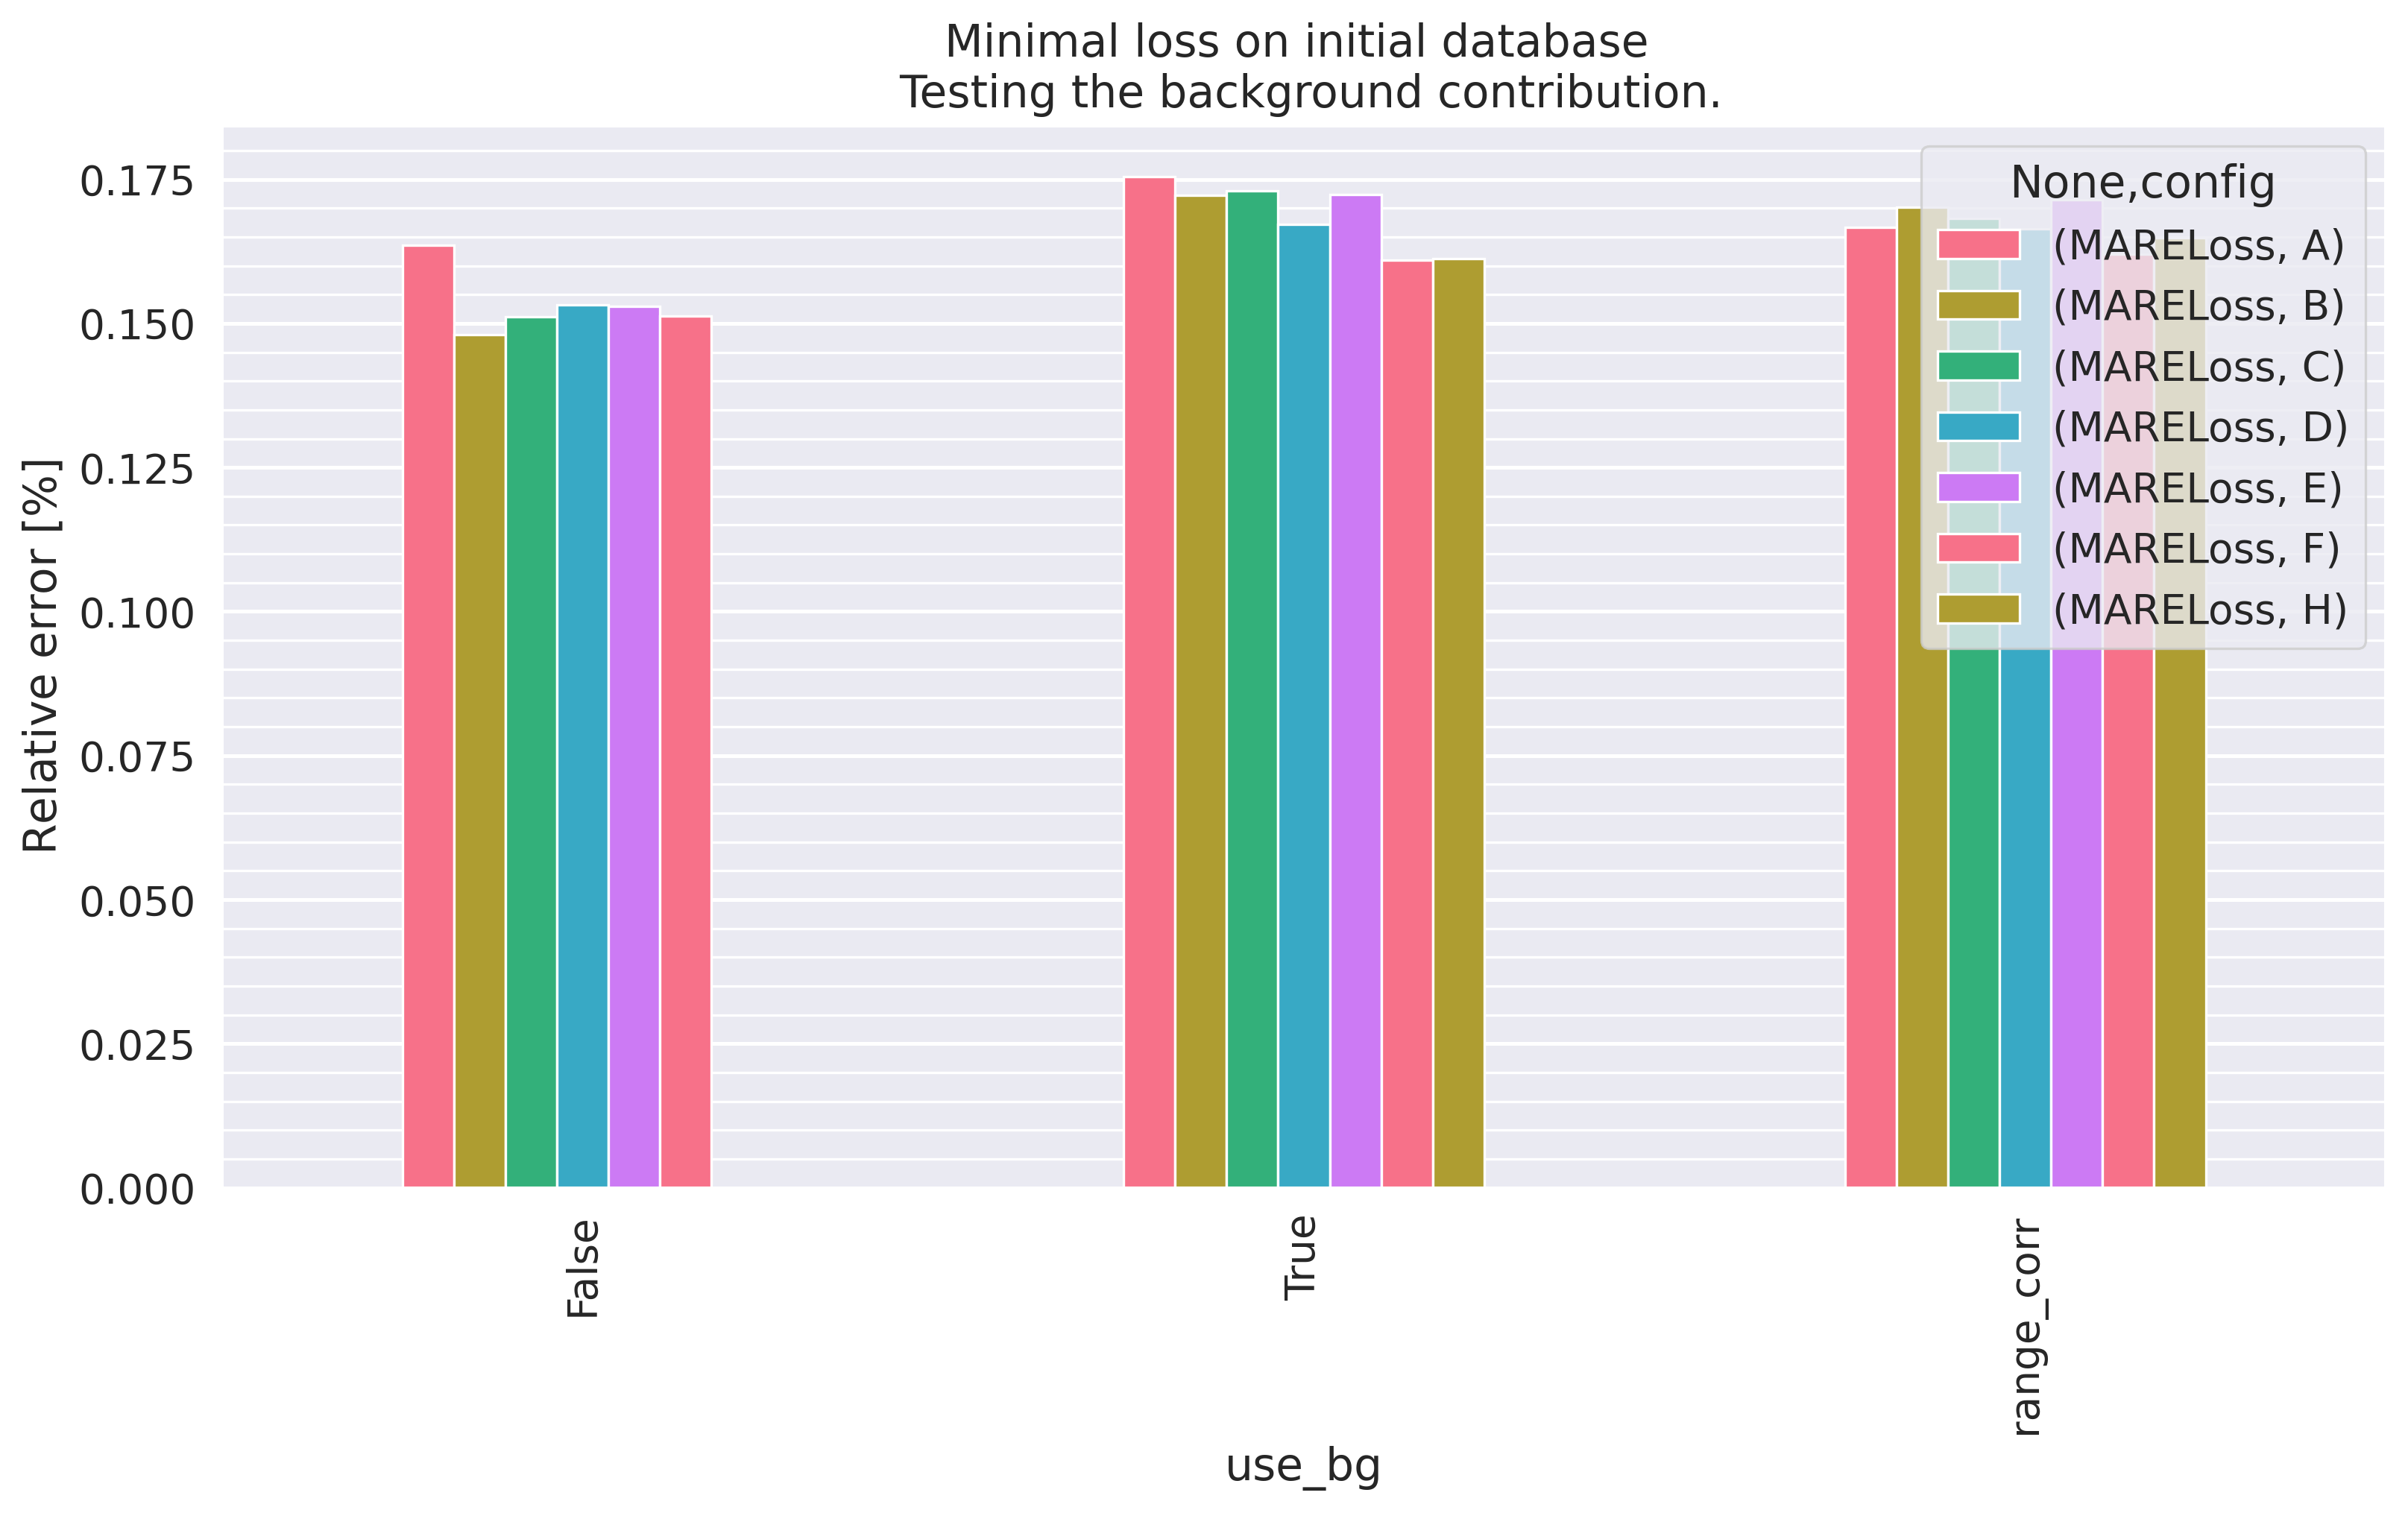

In [178]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial']
               [all_wavs_configABCD.wavelength==1064],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7), #ylim= [0.0, 0.175],
                 title='Minimal loss on initial database \n Testing the background contribution.')

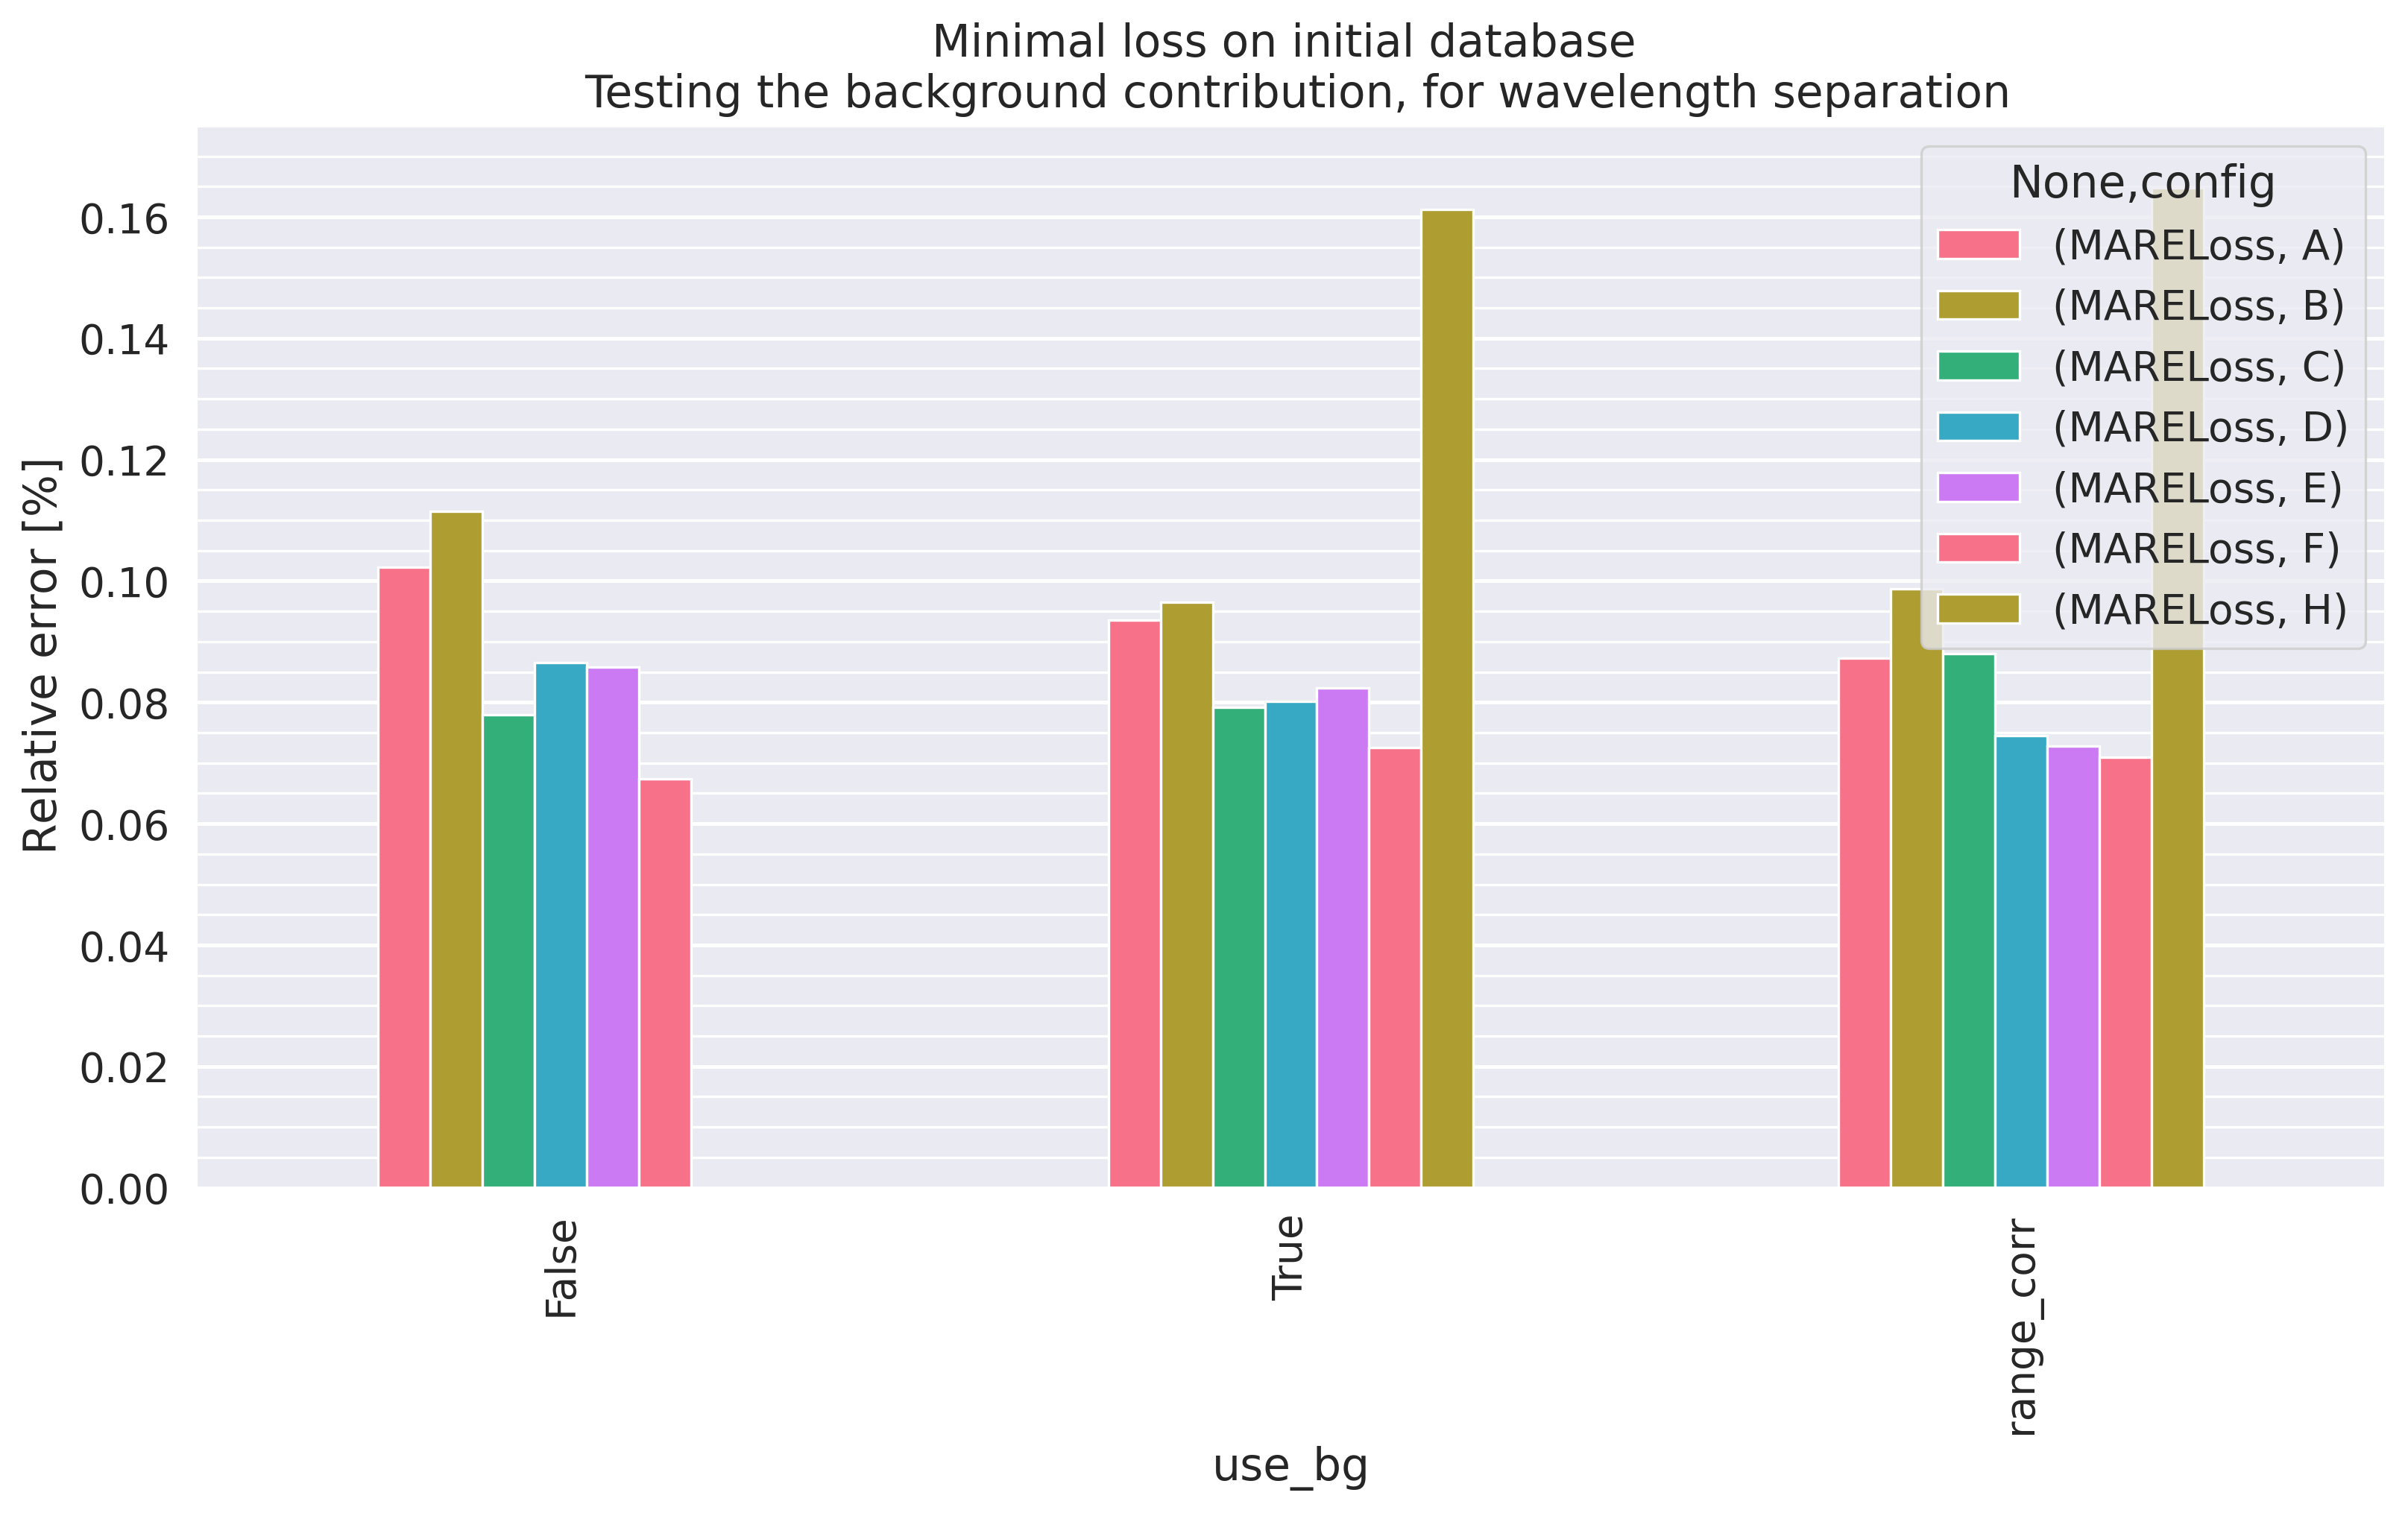

In [179]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7), ylim= [0.0, 0.175],
                 title='Minimal loss on initial database \n Testing the background contribution, for wavelength separation')

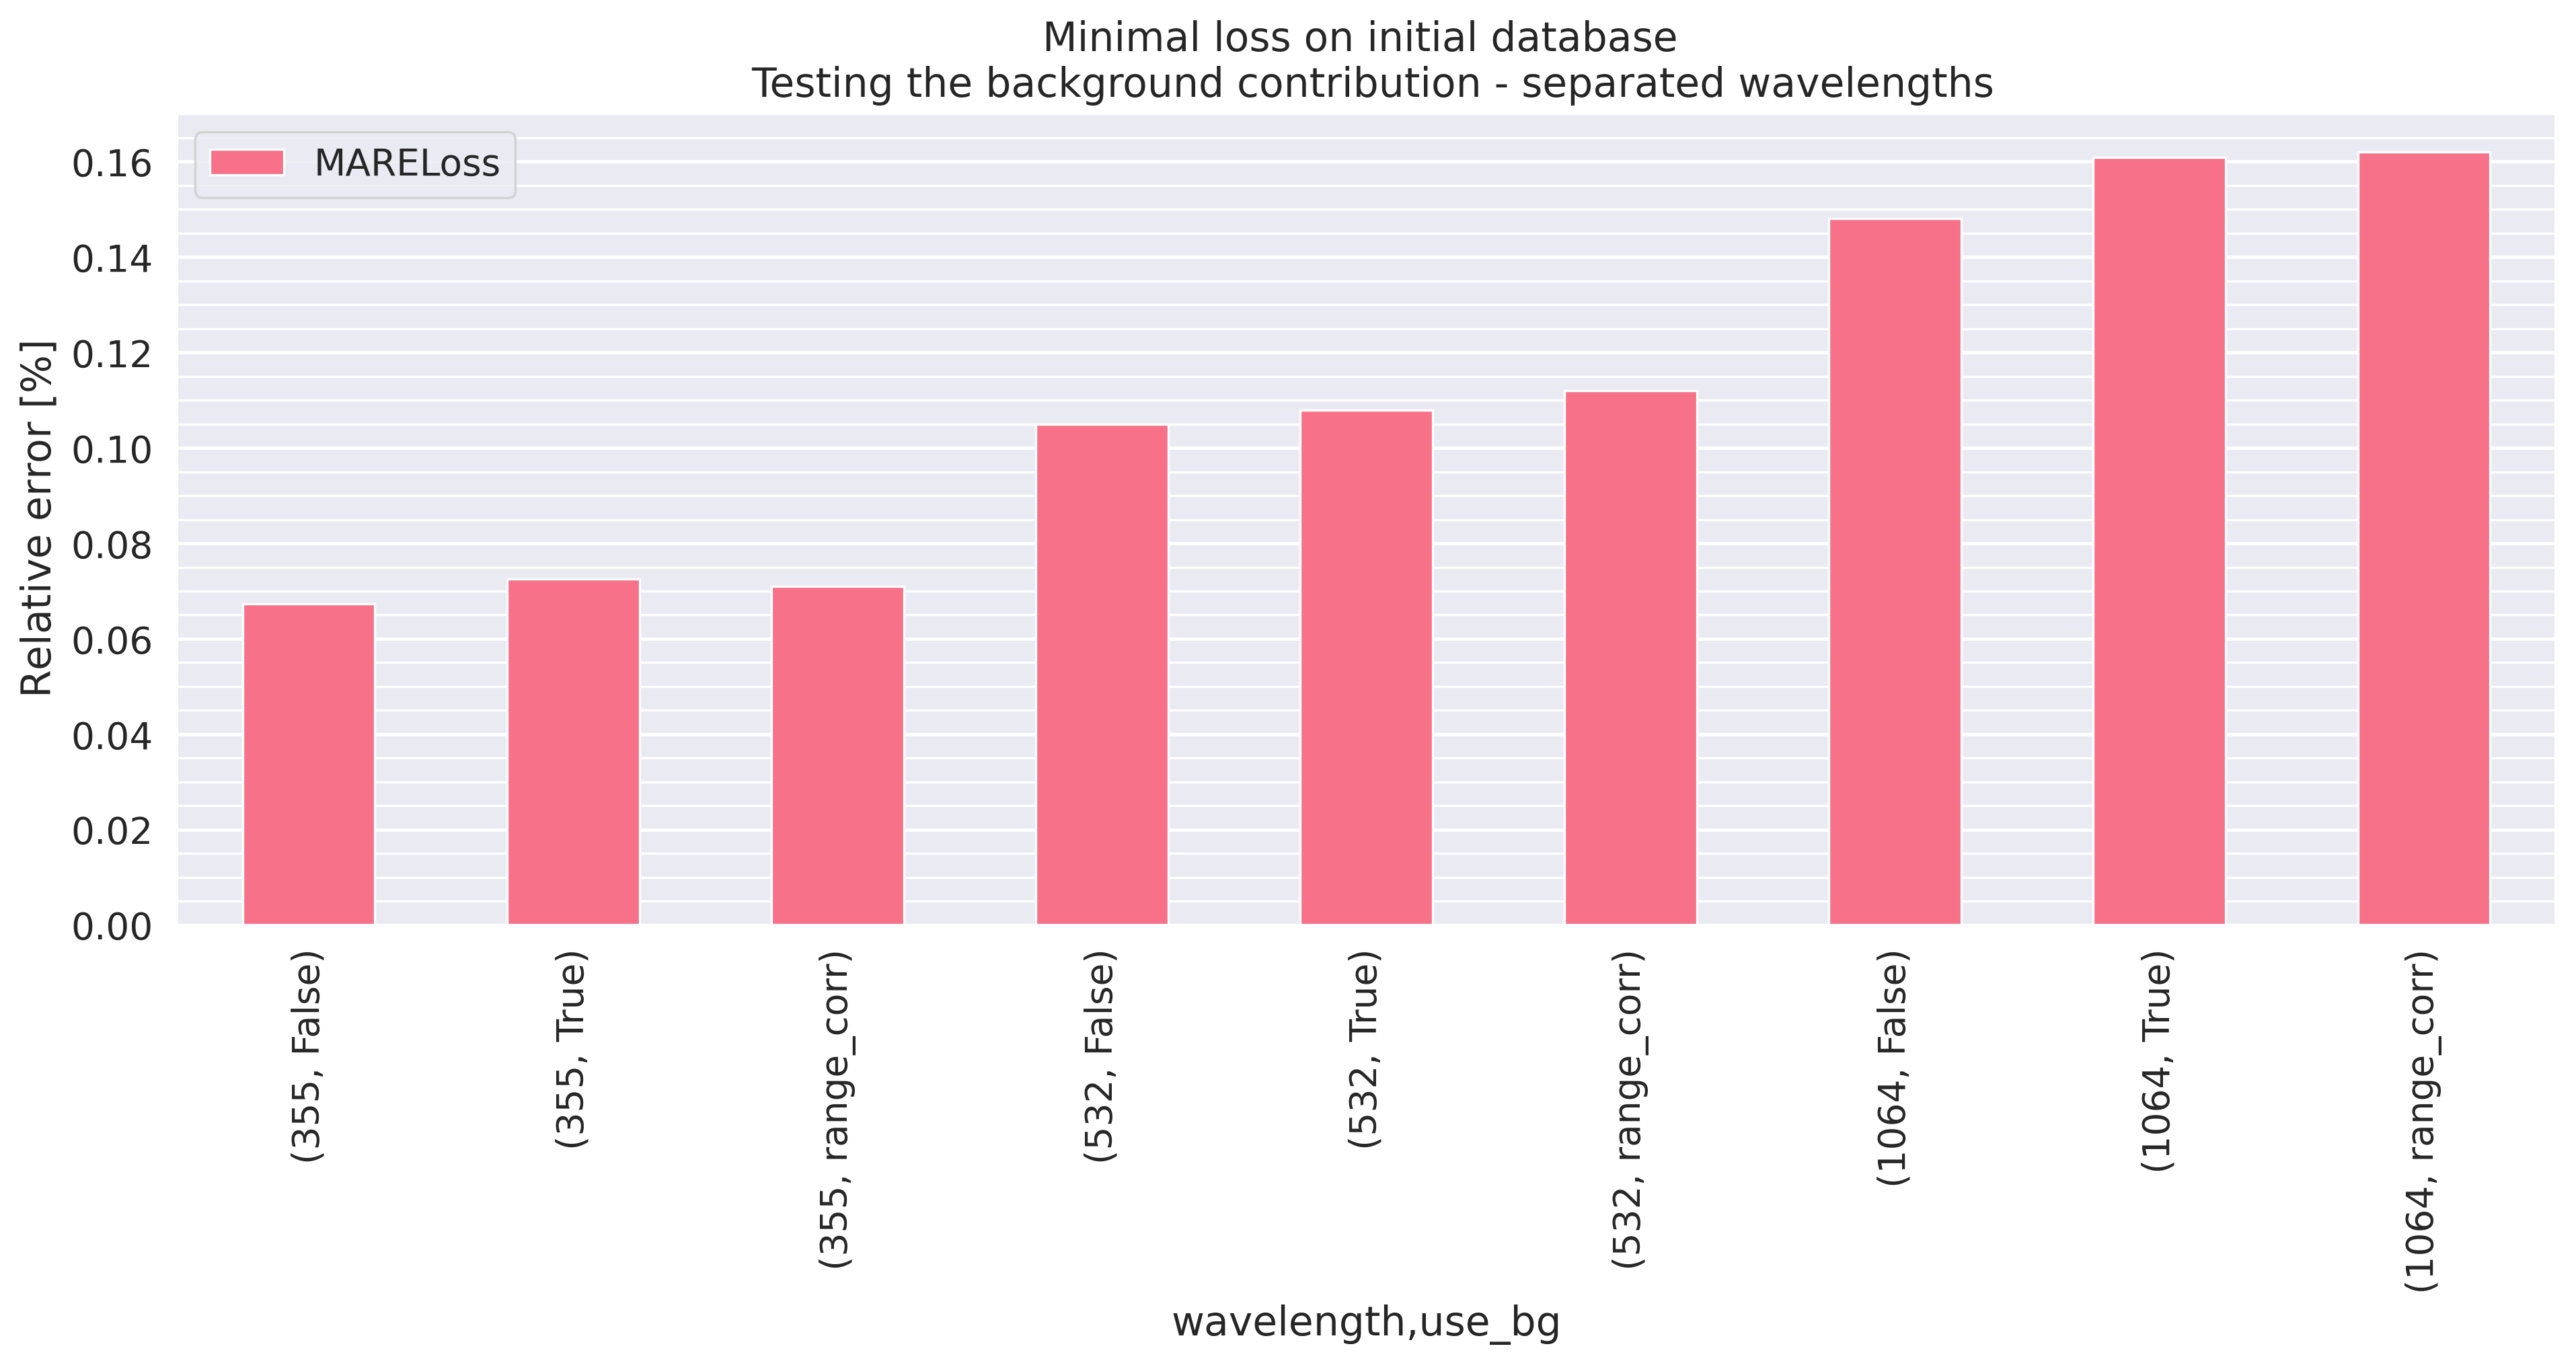

In [182]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               #columns= ['config'],
               index=['wavelength','use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(13, 7),
                 title='Minimal loss on initial database \n Testing the background contribution - separated wavelengths')


In [34]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial']
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min)

    plot_pivot_table(p_table, figsize=(11, 7), ylim= [0.0, 0.2],
                     title=f'Minimal loss on initial database \n'+
                           fr'Testing the background contribution - ${wavelength}[\rm nm]$')

No results to display!
No results to display!
No results to display!


C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\1902098380.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial']
C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\1902098380.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial']
C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\1902098380.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='initial']


C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\920632273.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]


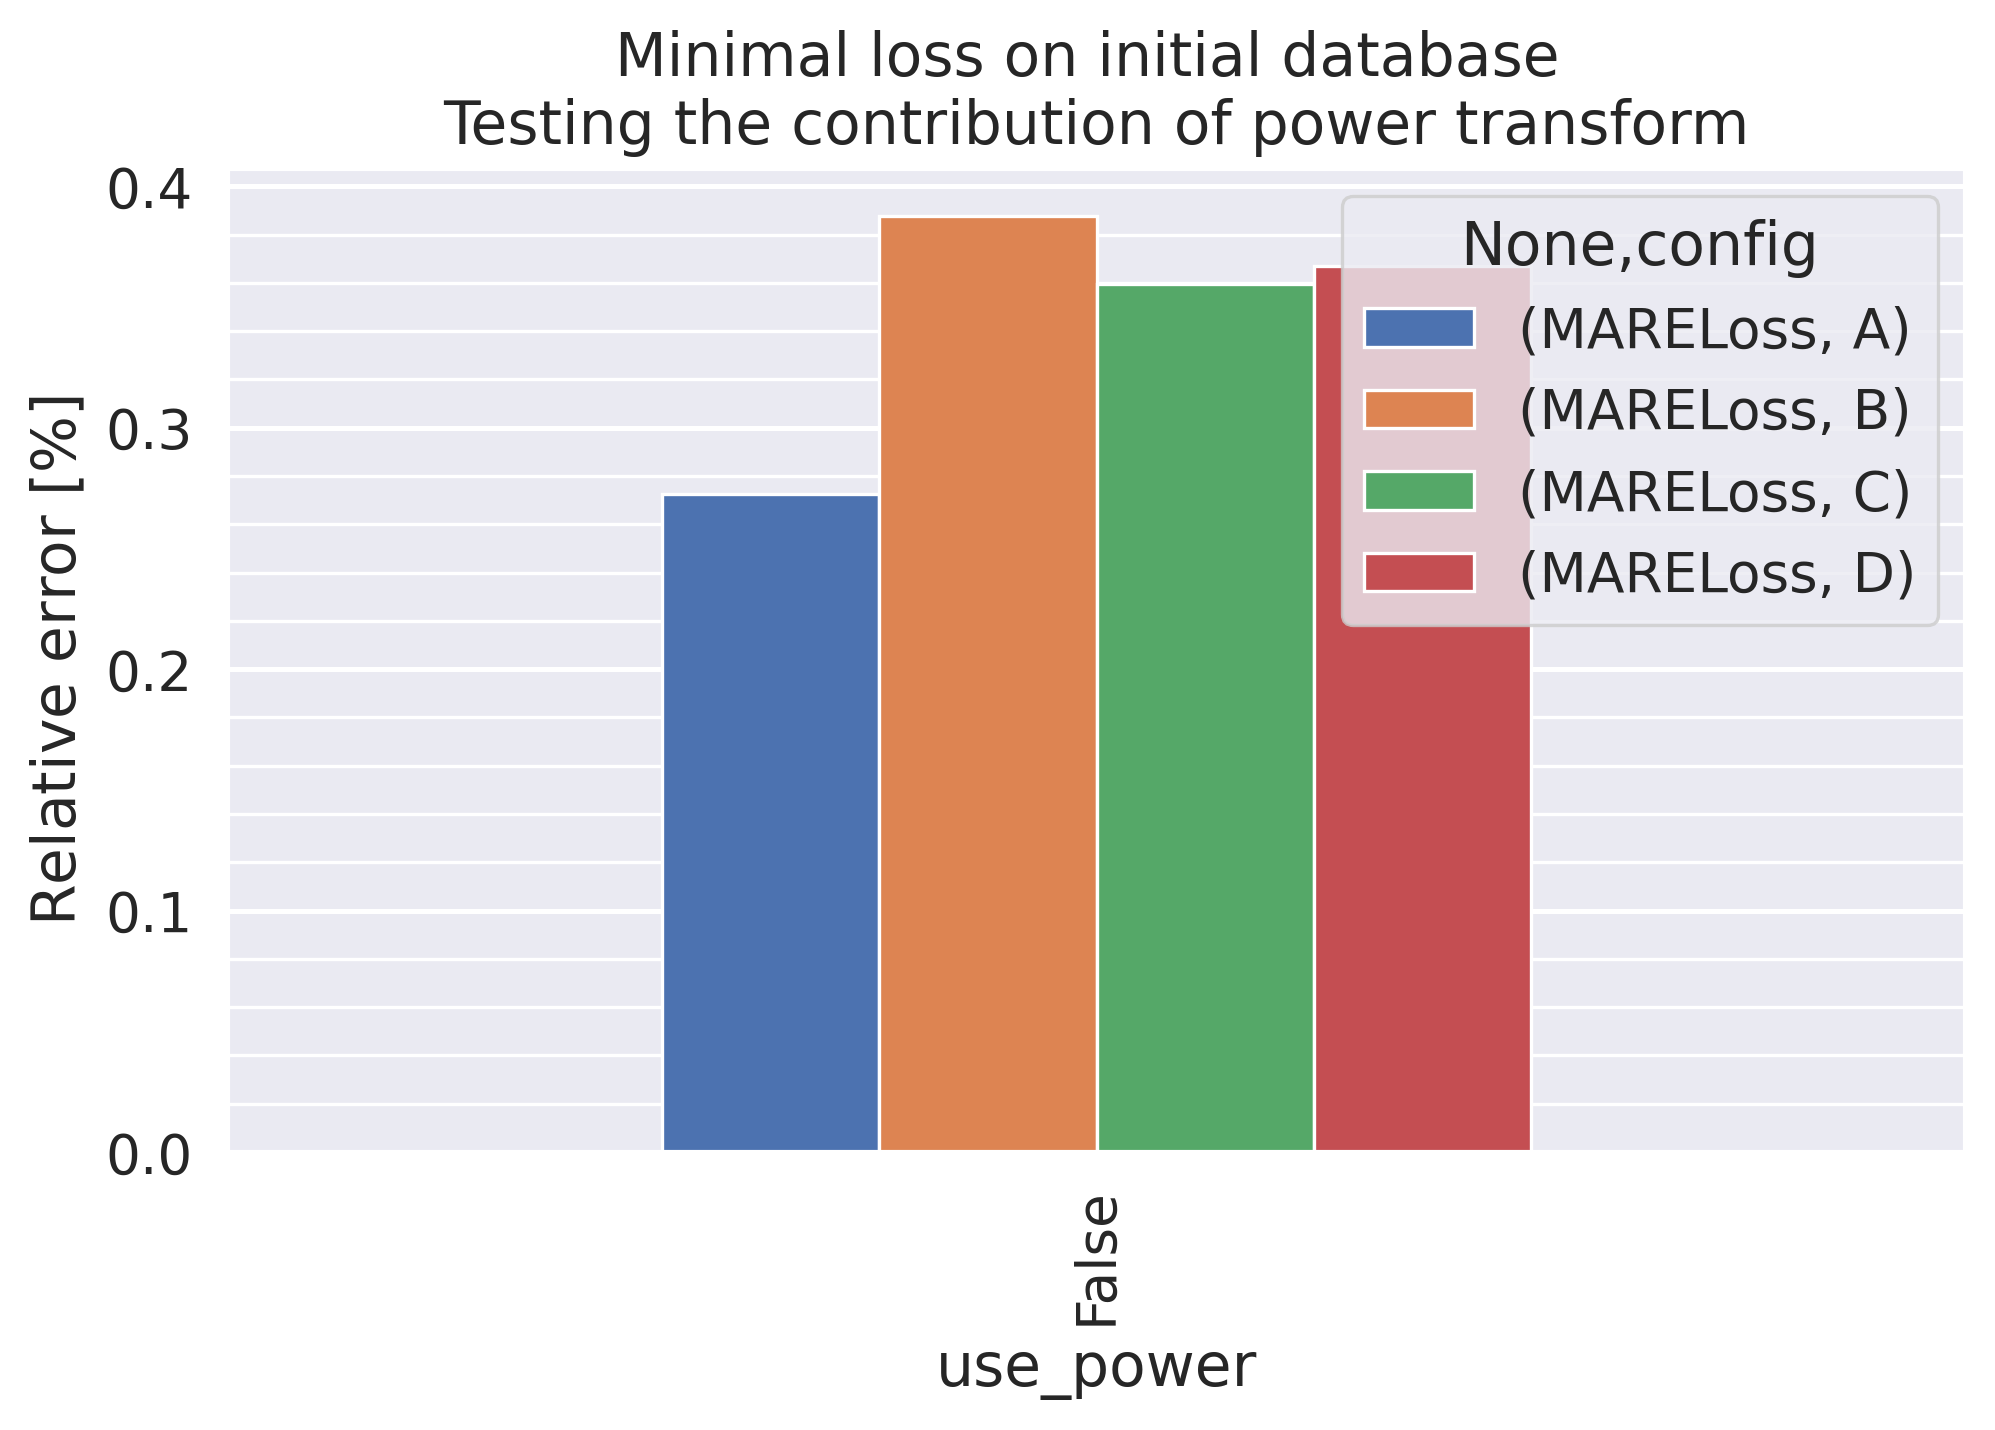

In [35]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
               [all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.db=='extended']
               [all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Minimal loss on initial database \n Testing the contribution of power transform ')

C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\174102017.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


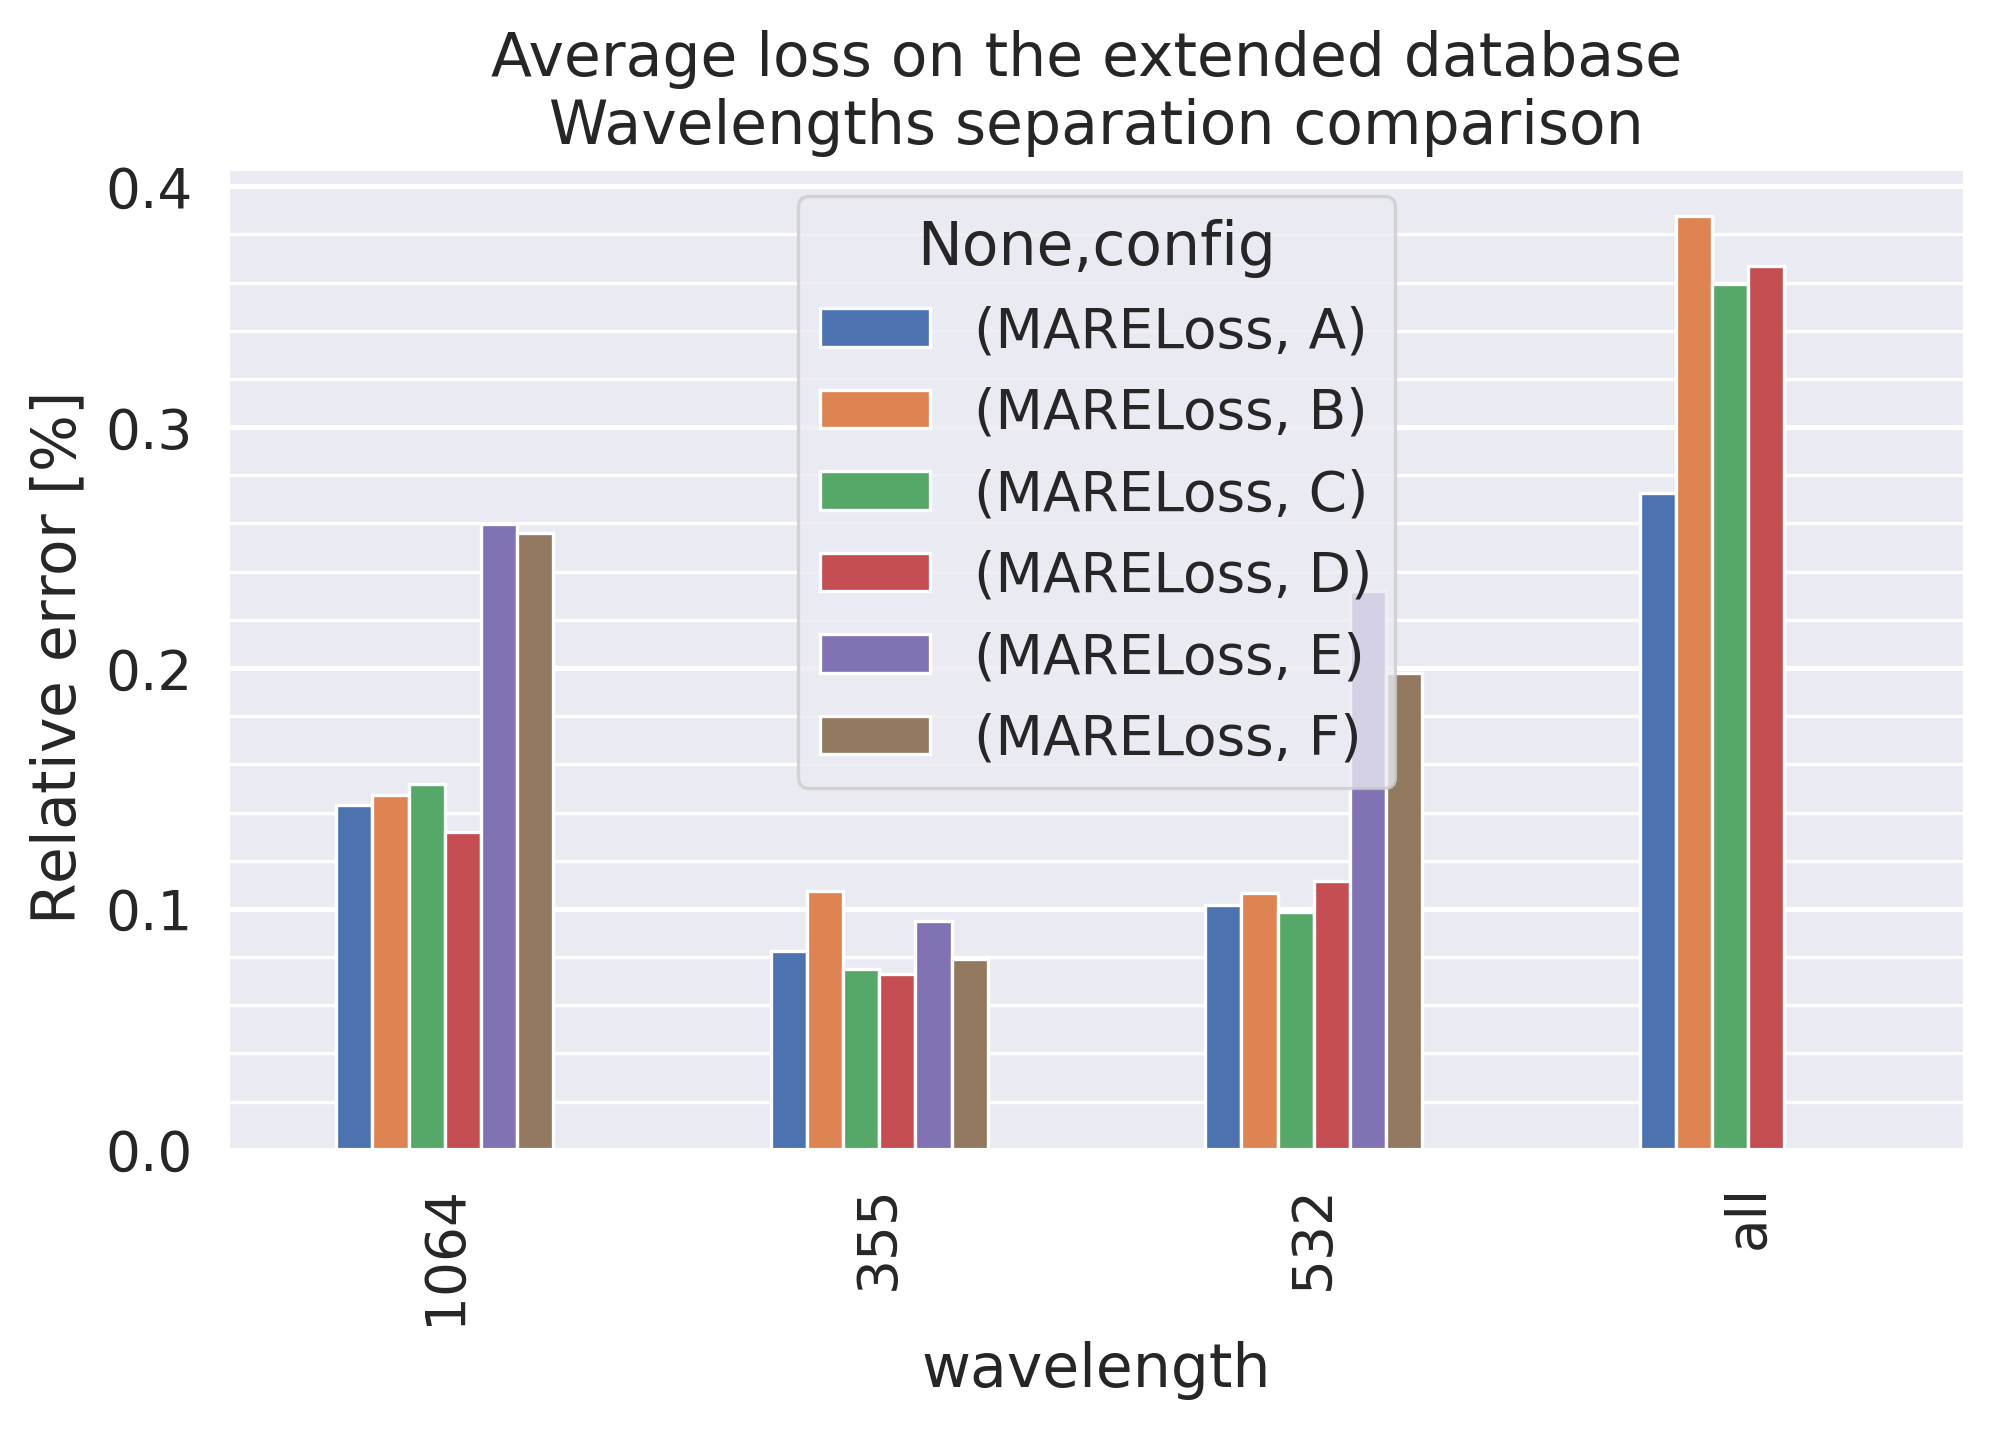

In [36]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.db=='extended'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Average loss on the extended database \n Wavelengths separation comparison ')

C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\2517525542.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


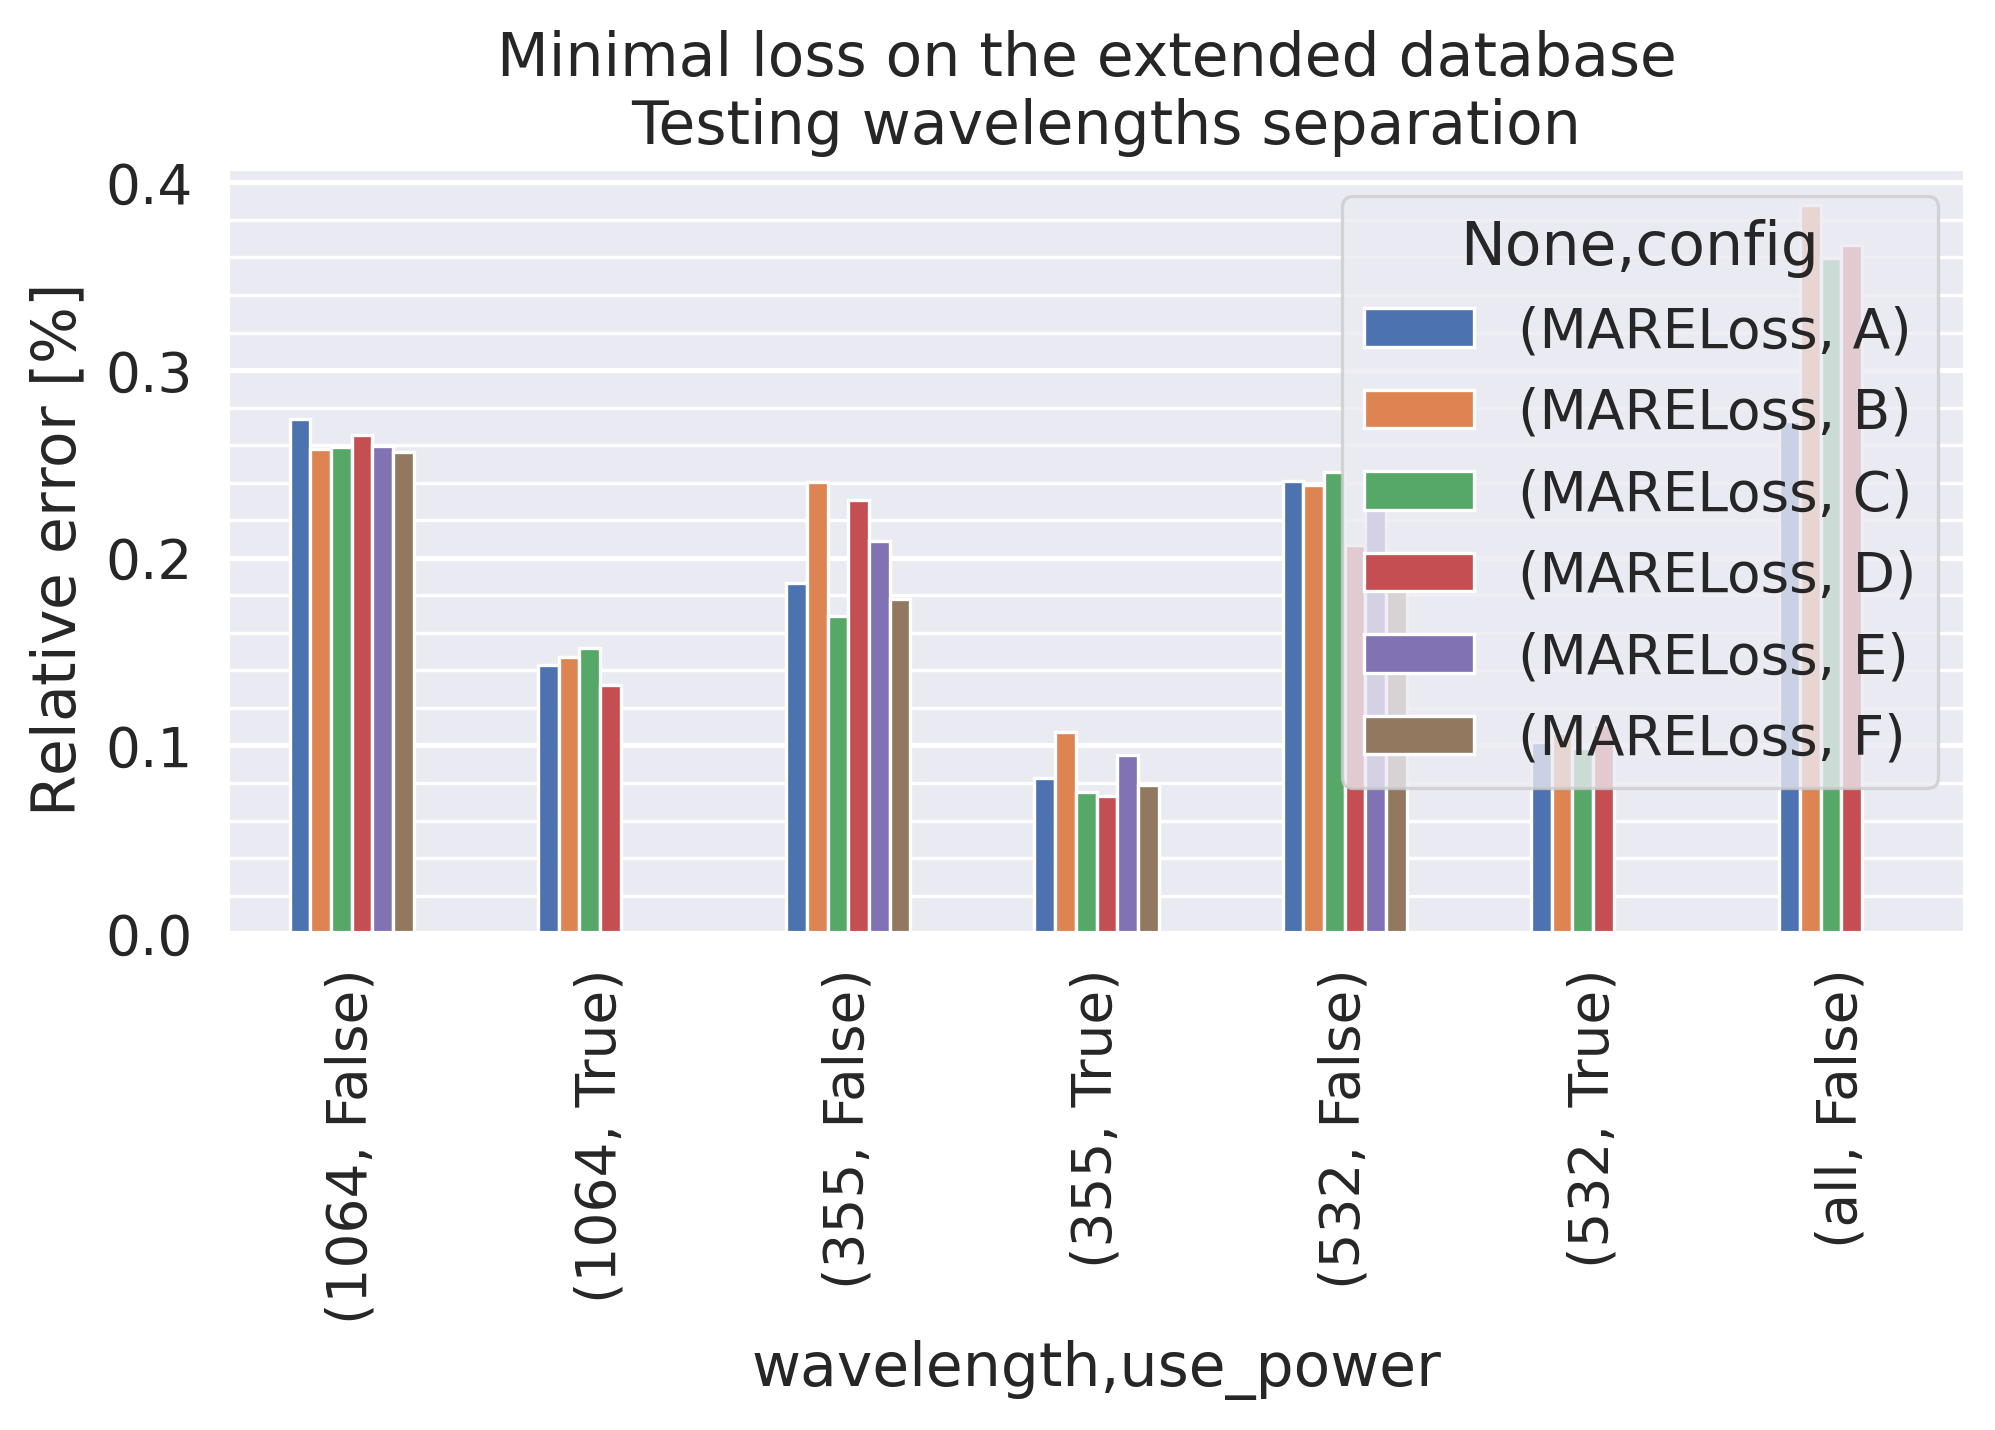

In [37]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.db=='extended'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_power'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(7, 5),
                 title='Minimal loss on the extended database \n Testing wavelengths separation')

C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\3289709638.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


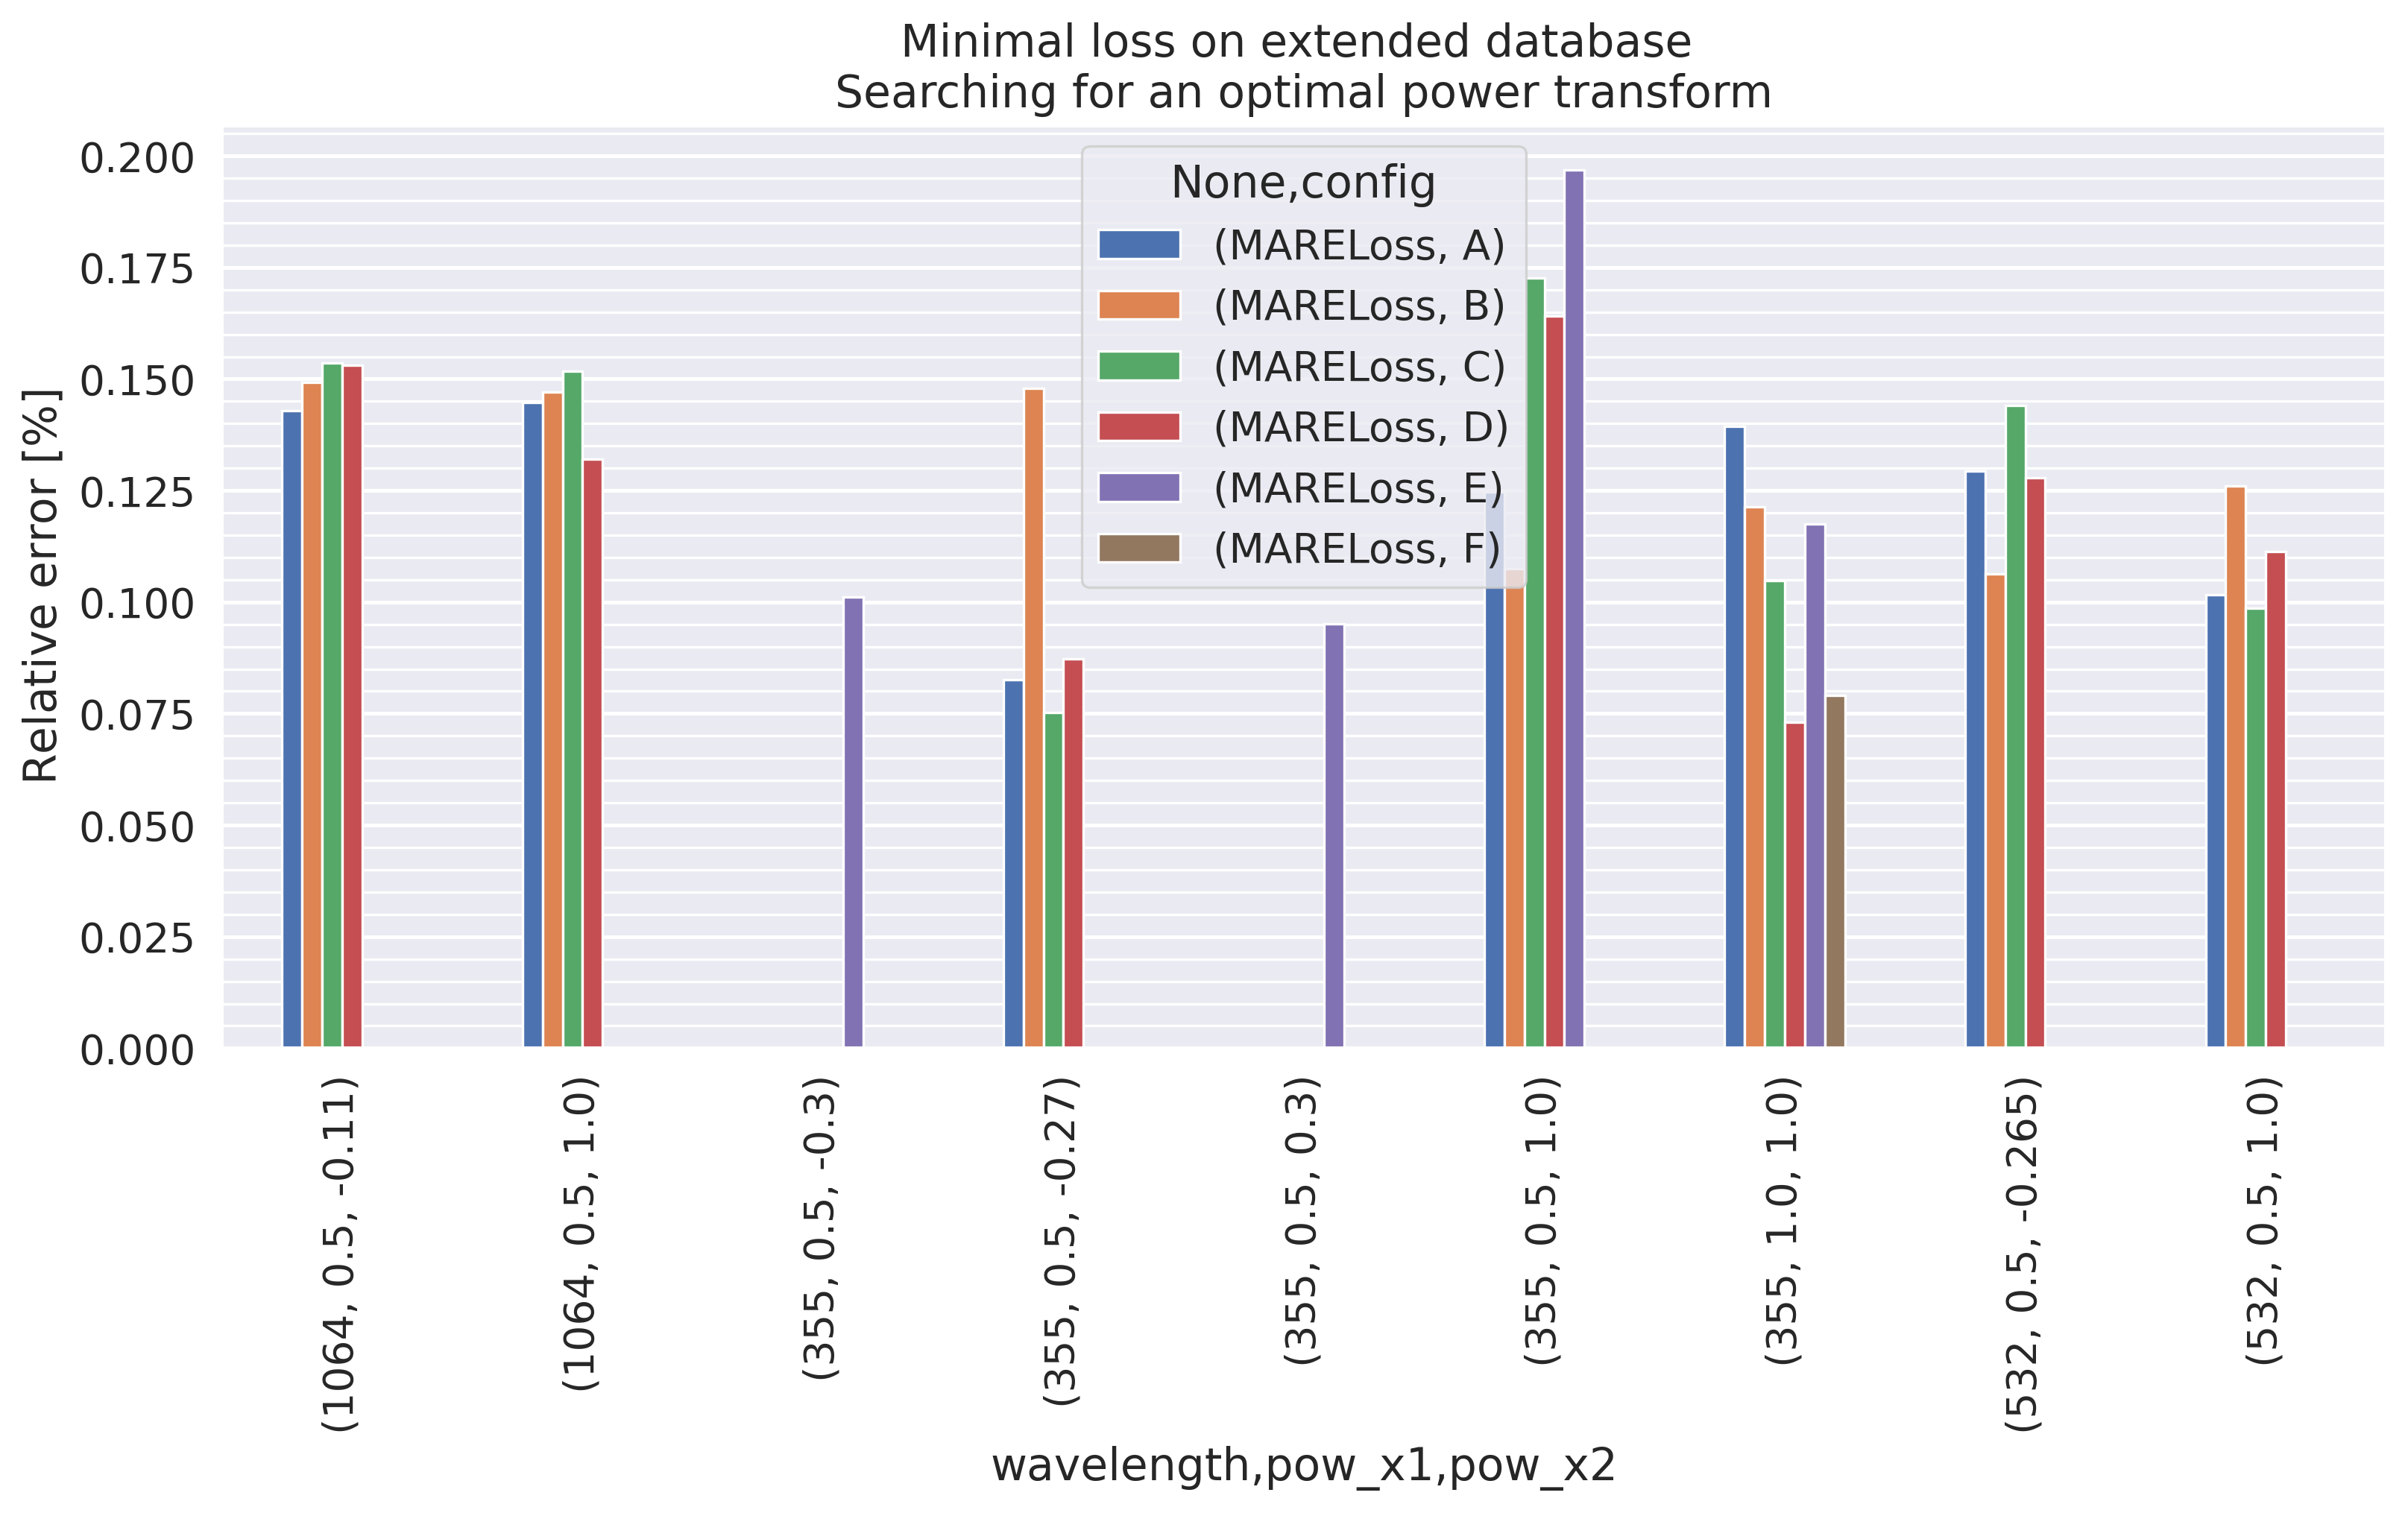

In [38]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.db=='extended']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7),
                 title='Minimal loss on extended database \n Searching for an optimal power transform ')

In [39]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['pow_x1','pow_x2','db'],
                   aggfunc=np.mean)

    plot_pivot_table(p_table, figsize=(11, 9),
                     title=f'Minimal loss on extended database \n Testing 1st model - '+
                           fr'${wavelength}[\rm nm]$' )

No results to display!
No results to display!
No results to display!


C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\3977630907.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\3977630907.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\3977630907.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\447757422.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='extended']


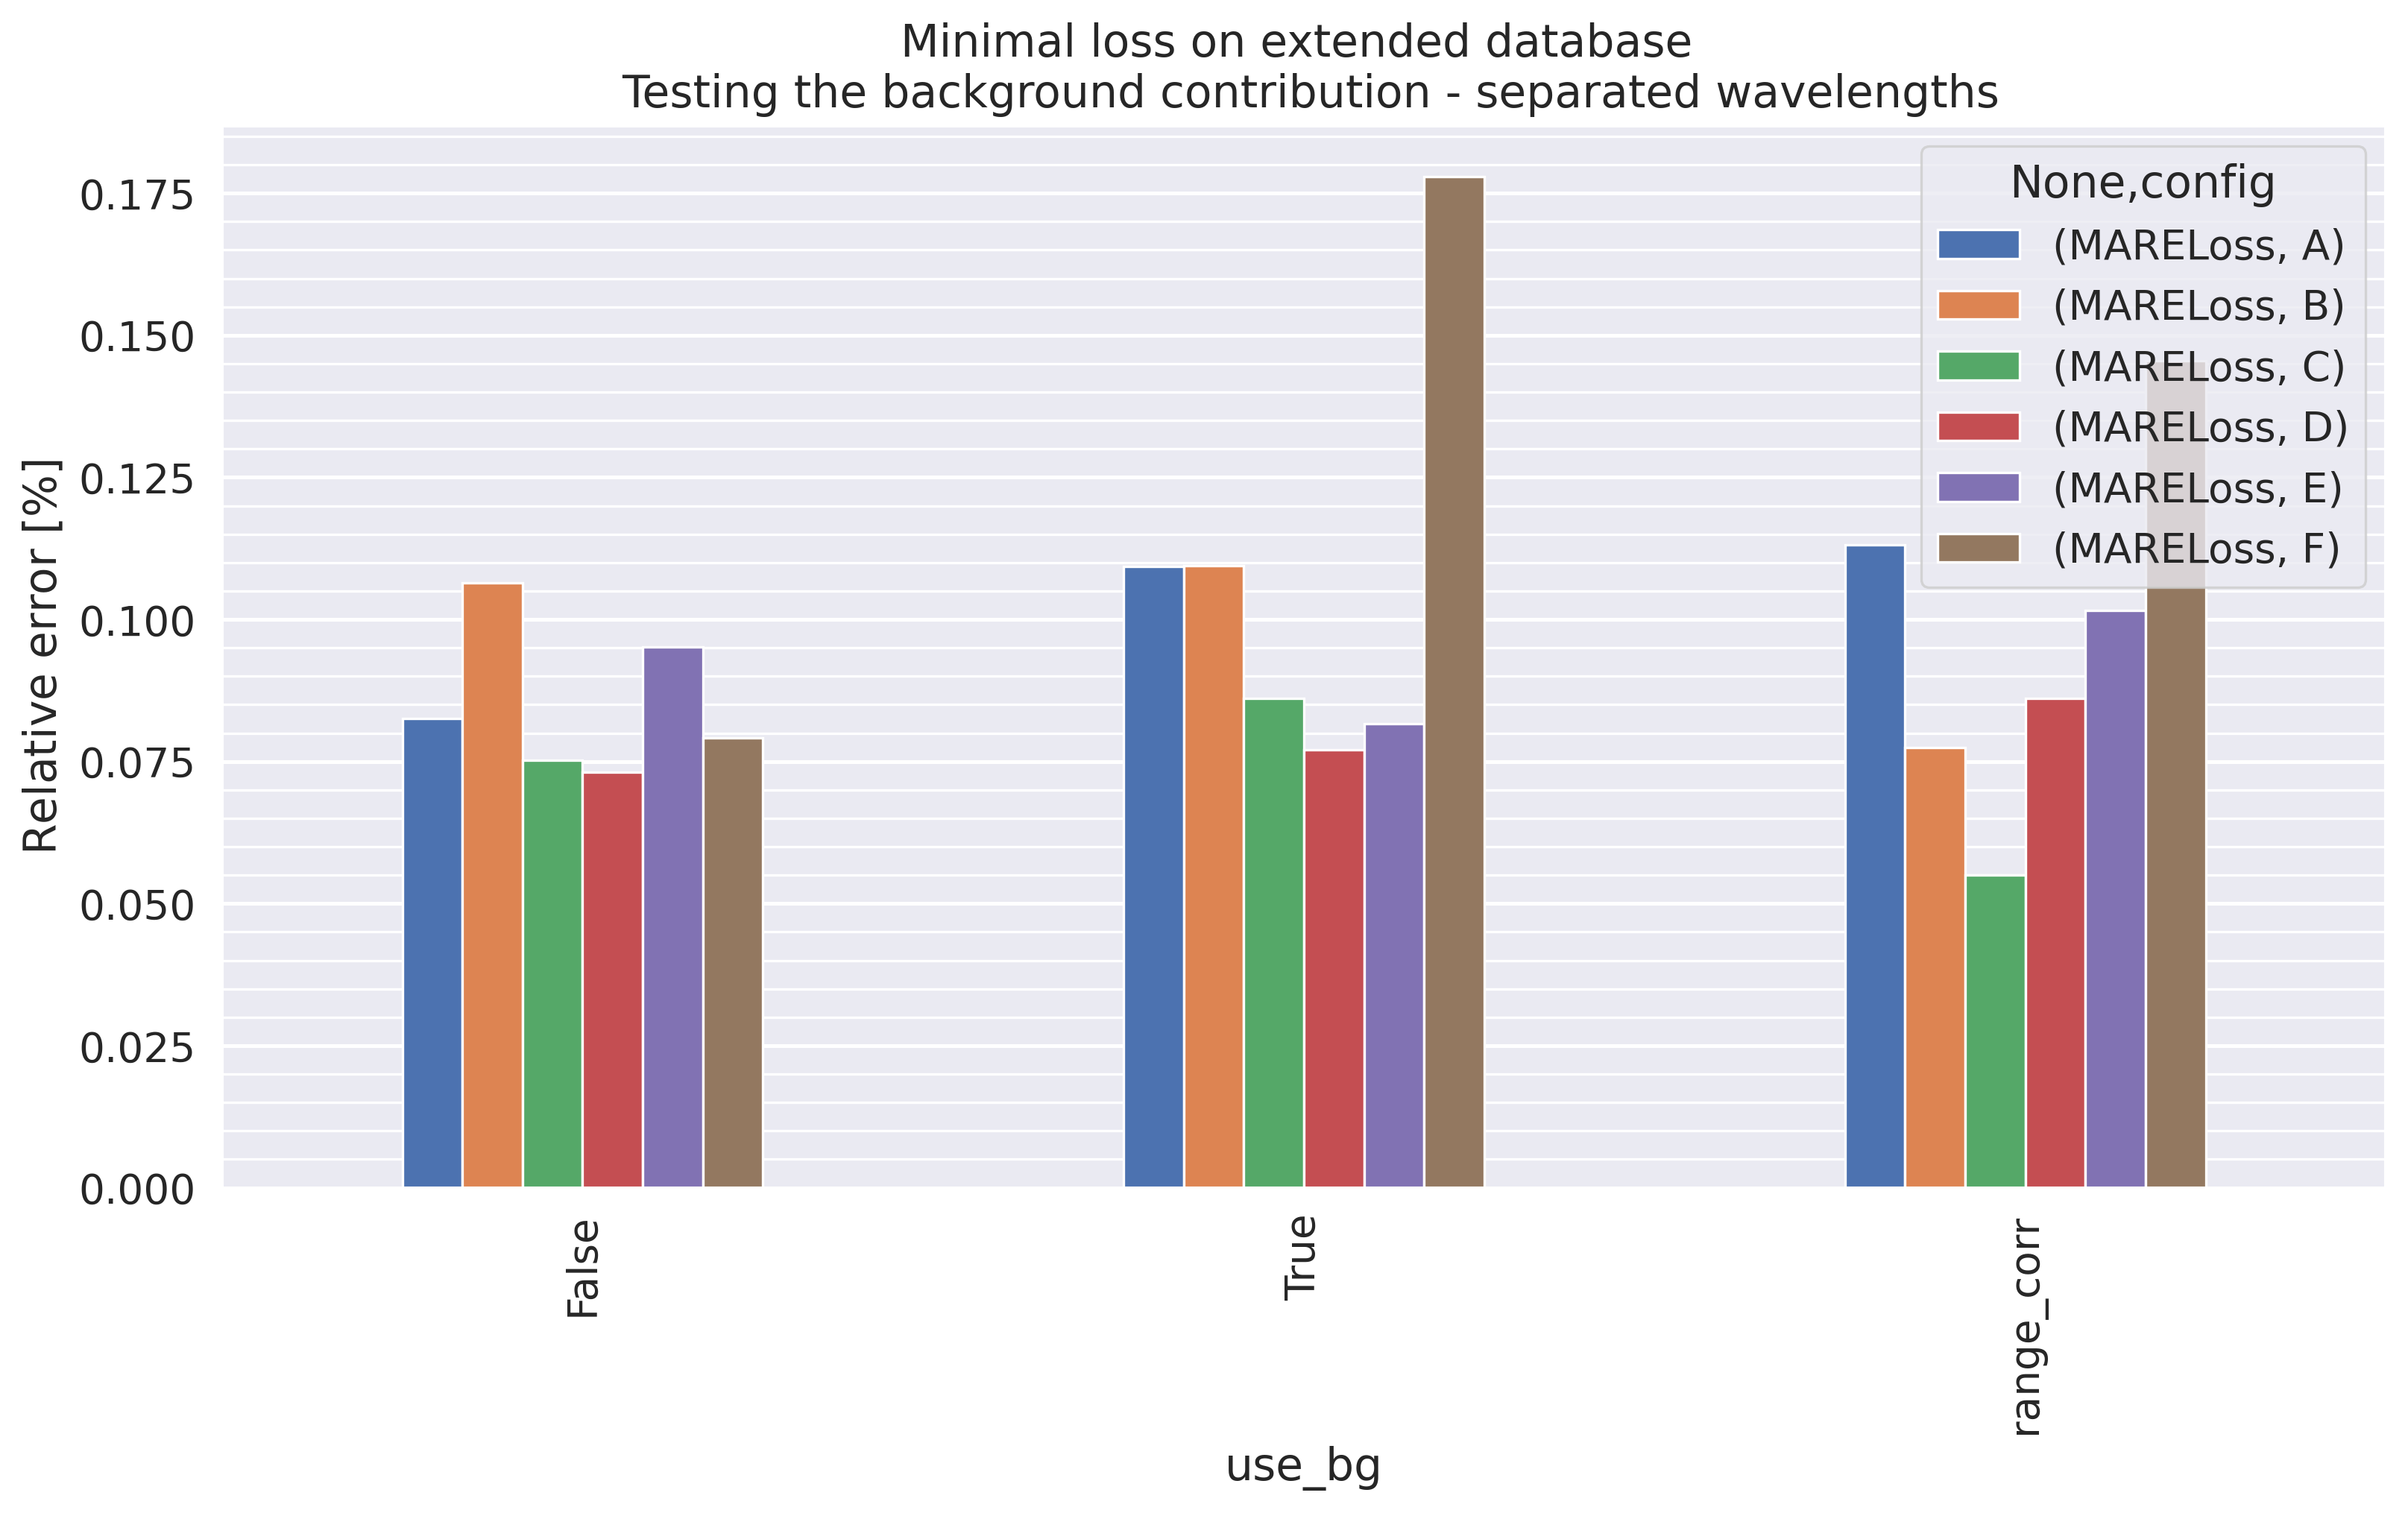

In [40]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.db=='extended']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(11, 7),
                 title='Minimal loss on extended database \n Testing the background contribution - separated wavelengths')

In [41]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power]
                   [all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.db!='initial_db_overlap'],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'db'],
                   aggfunc=np.min)

    plot_pivot_table(p_table, figsize=(11, 9), ylim= [0.0, 0.2],
                     title=f'Minimal loss on extended database \n Testing 2nd model - '+
                           fr'${wavelength}[\rm nm]$' )
    

No results to display!
No results to display!
No results to display!


C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\4217097435.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power]
C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\4217097435.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power]
C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\4217097435.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power]


In [42]:
for wavelength in [355,532,1064]:
    p_table = pd.pivot_table(all_wavs_configABCD
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min)

    plot_pivot_table(p_table, figsize=(11, 7), ylim= [0.0, 0.2],
                     title=f'Minimal loss on extended database \n'+
                           fr'Testing the background contribution - ${wavelength}[\rm nm]$')

No results to display!
No results to display!
No results to display!


C:\Users\addalin\AppData\Local\Temp\ipykernel_7744\415540291.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False]


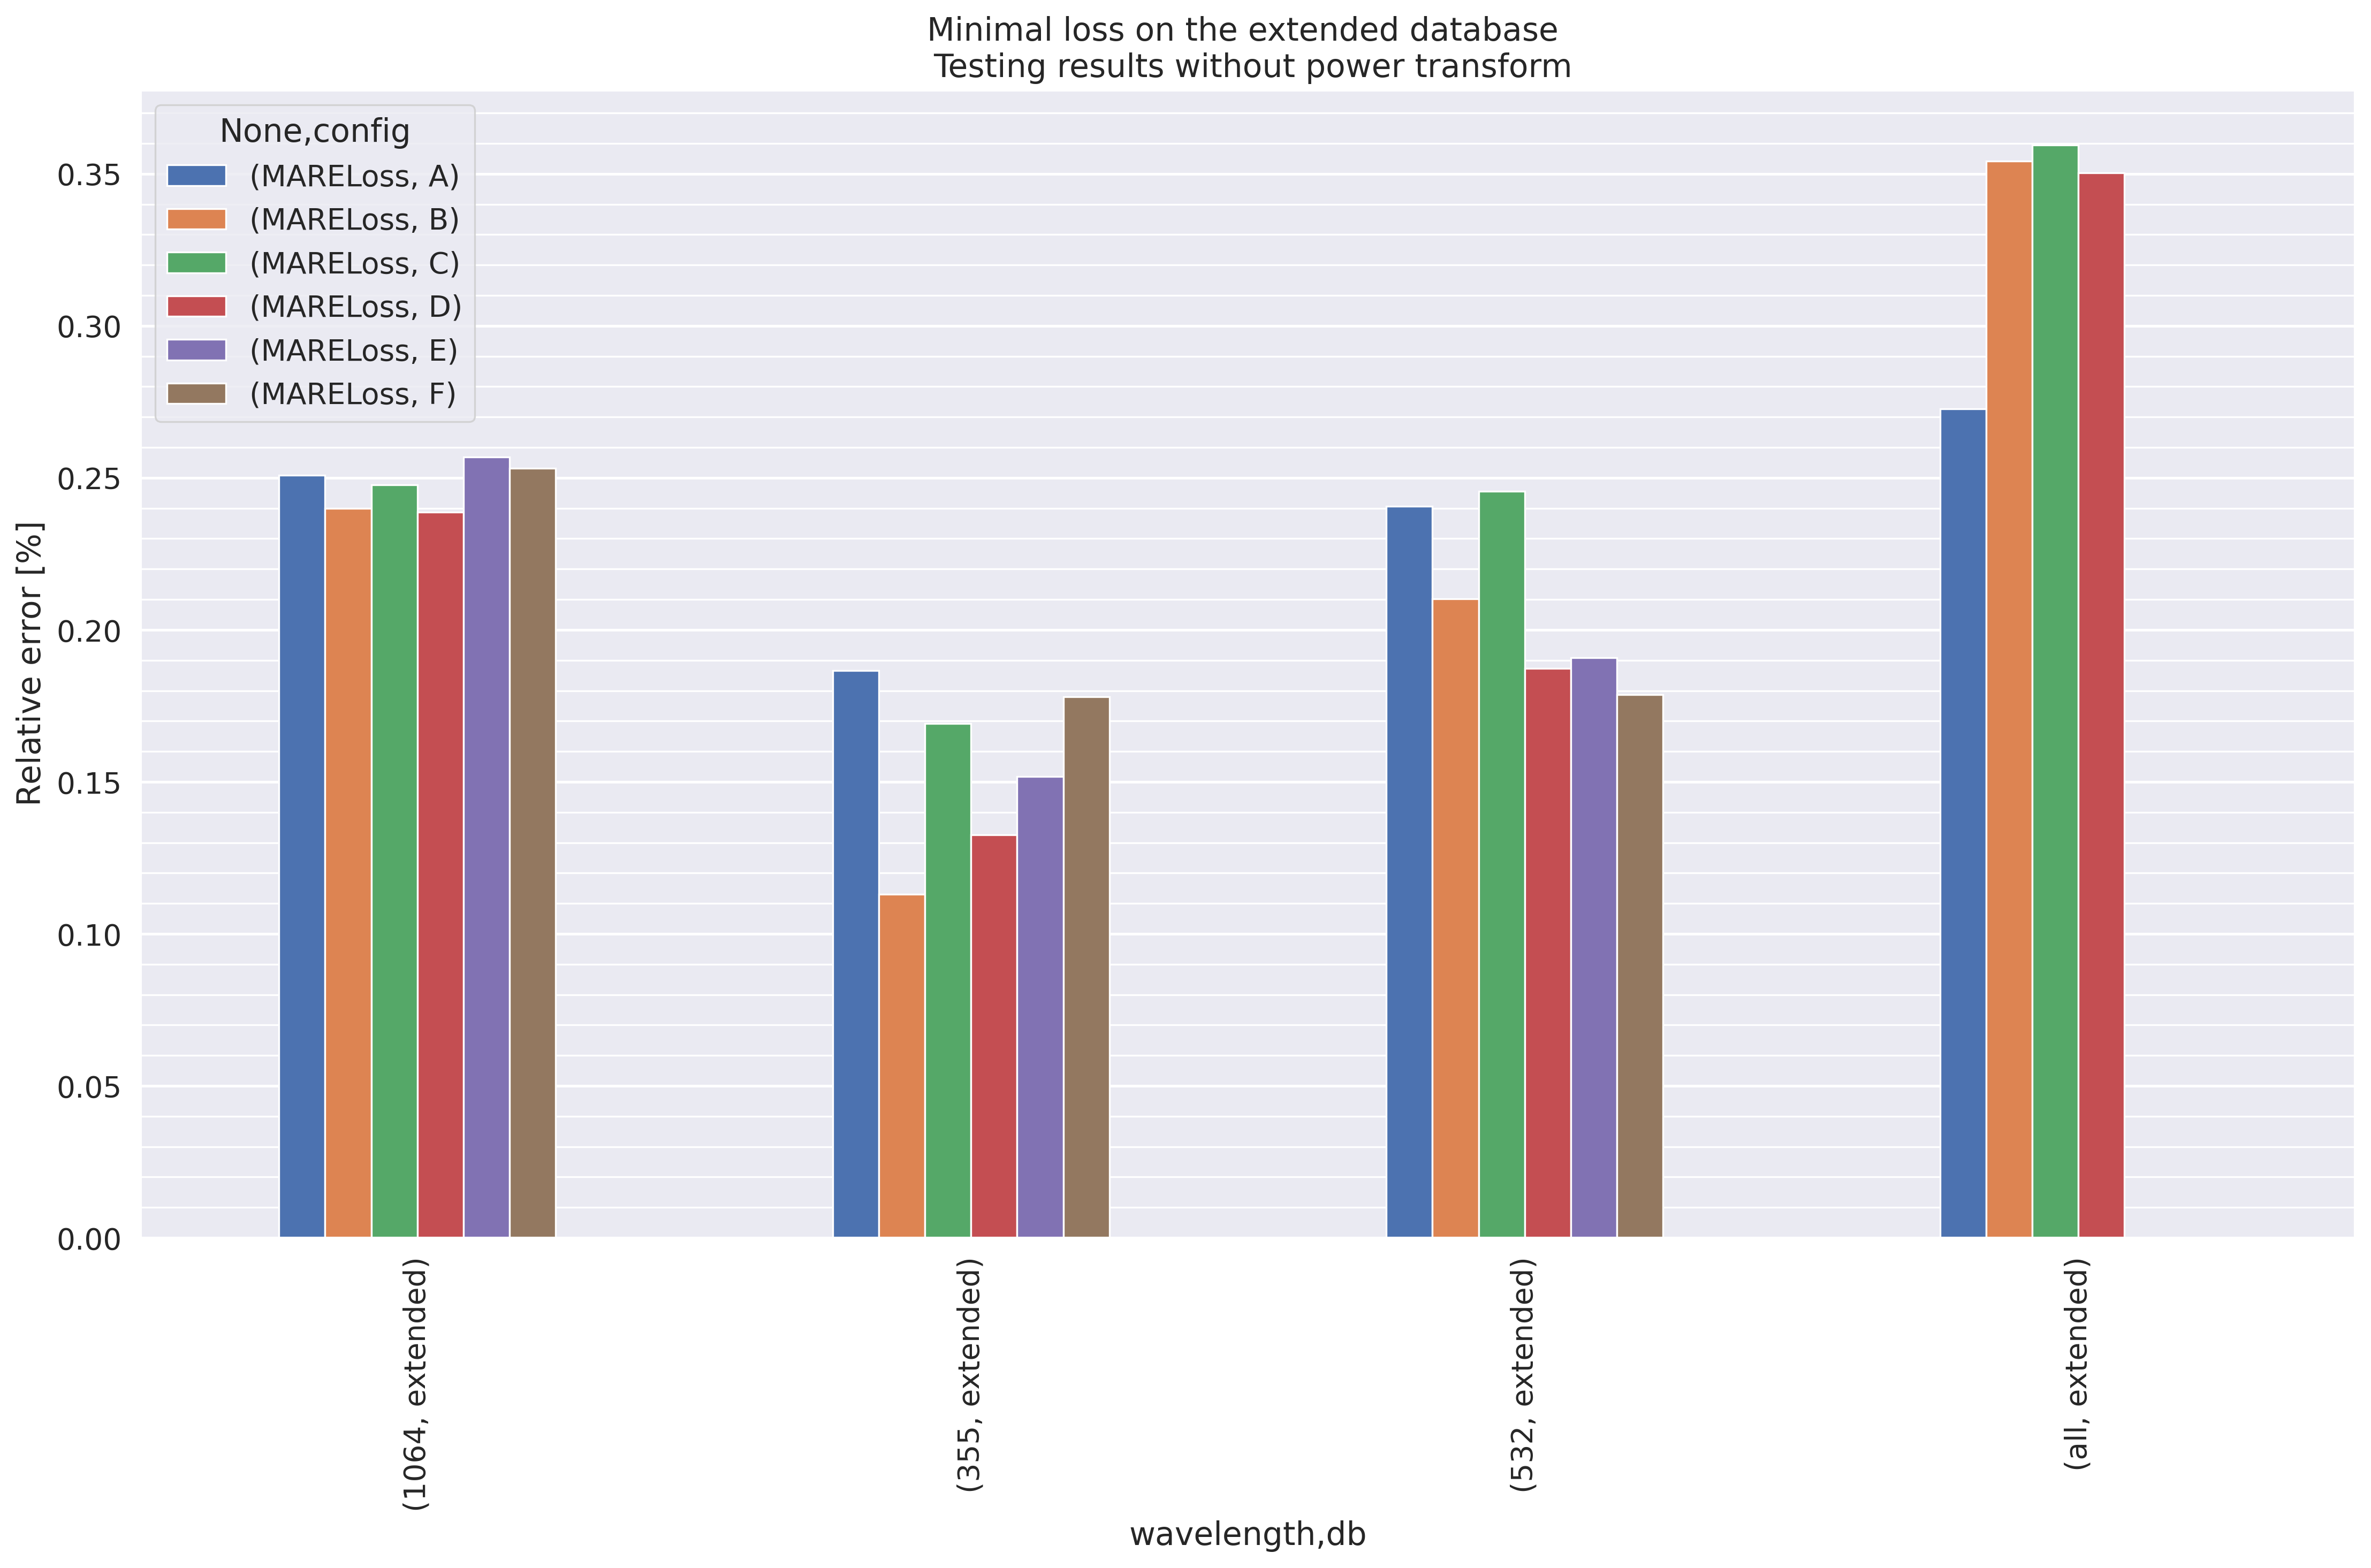

In [43]:
p_table = pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False]
               [all_wavs_configABCD.db=='extended'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','db'],#'use_bg'],
               aggfunc=np.min)

plot_pivot_table(p_table, figsize=(15, 10),
                 title='Minimal loss on the extended database \n Testing results without power transform')


